**Objetivo**

Procederemos a crear un dataframe de ventas que nos permita llevar a cabo un análisis detallado y preciso. Para ello, comenzaremos importando los distintos datasets proporcionados por la empresa. Realizaremos un análisis preliminar de cada uno para identificar las columnas clave que aporten información valiosa para el análisis de ventas. Esto nos permitirá estructurar los datos de forma óptima y obtener insights relevantes sobre el rendimiento de las ventas.

In [ ]:
# comenzamos importando las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cargamos todas las tablas de las que disponemos sin contar con la primera columna de cada una de ellas que no aporta información.

# tabla relativa a a las ventas
sales = pd.read_csv('/content/drive/MyDrive/TFM/datasets/sales.csv',usecols=lambda column: column != 'Unnamed: 0')

#tabla relativa a información sobre la actividad comercial de los clientes
commercial_activity = pd.read_csv('/content/drive/MyDrive/TFM/datasets/customer_commercial_activity.csv',usecols=lambda column: column != 'Unnamed: 0')

#tabla que informa sobre los productos adquiridos cada mes por cada cliente
products = pd.read_csv('/content/drive/MyDrive/TFM/datasets/customer_products.csv',usecols=lambda column: column != 'Unnamed: 0')

#tabla que aporta información personal de cada cliente como edad, region, país, género
sociodemographics = pd.read_csv('/content/drive/MyDrive/TFM/datasets/customer_sociodemographics.csv',usecols=lambda column: column != 'Unnamed: 0')

# tabla que muestra los productos que están a la venta
products_description = pd.read_csv('/content/drive/MyDrive/TFM/datasets/product_description.csv',usecols=lambda column: column != 'Unnamed: 0')

# EDA y Data Preparation

### FUNCIONES y CONSTANTES

Creamos variables que vamos a reutilizar en diferentes partes del codigo

In [ ]:
#Creamos una lista, con el nombre de todos los productos que ofertamos a los clientes
productos = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll',
             'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount']

Vamos a crear una sección dedicada donde podamos localizar fácilmente todas las funciones definidas en el documento.

In [ ]:
def agrupar_valores(df, columnas, n_registros):
    """
    Agrupa los valores que tengan menos de n_registros registros y los nulos en una única categoría llamada 'N/A'.

    Parameters:
    dataframe: DataFrame de entrada.
    columnas: Lista de columnas a transformar.

    Return:
    DataFrame transformado.
    """

    for columna in columnas:
        # Contar los valores de la columna, incluyendo los nulos
        conteo_valores = df[columna].value_counts(dropna=False)

        # Identificar los valores a agrupar (menos de n_registros)
        valores_a_agrupar = conteo_valores[conteo_valores < n_registros].index

        # Crear una máscara para los valores a agrupar y nulos
        mask = df[columna].isin(valores_a_agrupar) | df[columna].isnull()

        # Reemplazar los valores según la máscara
        df.loc[mask, columna] = 'DESCONOCIDO'

    return df

In [ ]:
def number_to_category(df, columnas):
    """
    Convierte las columnas numéricas especificadas de un DataFrame a categóricas.

    Parametros:
    df (DataFrame): DataFrame original.
    columnas (list): Lista de nombres de las columnas a convertir.

    Return:
    DataFrame con las columnas convertidas a categóricas.
    """
    assert isinstance(df,pd.DataFrame), "El primer parámetro de entrada no es un Dataframe."
    assert isinstance(columnas,list), "El segundo parámetro de entrada no es una lista."

    df[columnas] = df[columnas].astype('object')

    return df

In [ ]:
def OHE(df, columns):
    """
    Realiza One Hot Encoding en las columnas especificadas de un DataFrame.

    Parameters:
    df (pandas.DataFrame): El DataFrame sobre el que se realizará OHE.
    columns (list): Lista de nombres de las columnas para aplicar OHE.

    Returns:
    pandas.DataFrame: DataFrame con las columnas codificadas.
    """
    return pd.get_dummies(df, columns=columns)

In [ ]:
def frequency_encoding(df, column):
    """
    Realiza Frequency Encoding en la columna especificada de un DataFrame.

    Parameters:
    df (pandas.DataFrame): El DataFrame en el que se realizará el Frequency Encoding.
    column (str): El nombre de la columna para aplicar el Frequency Encoding.

    Returns:
    pandas.DataFrame: DataFrame con la columna codificada por frecuencia.
    """
    freq_encoding = df.groupby(column)[column].transform('count') / len(df)
    df[column] = freq_encoding
    return df

In [ ]:
def calculate_correlation(df, top_n=20, cmap='coolwarm'):
    """
    Calcula la correlación entre las columnas numéricas de un DataFrame y devuelve las correlaciones
    más altas y más bajas, así como la visualización con un gradiente de color.

    Parameters:
    df (pandas.DataFrame): El DataFrame en el que se calculará la correlación.
    top_n (int): El número de correlaciones más altas y más bajas que se mostrarán. Default es 20.
    cmap (str): El color del mapa de calor para la visualización. Default es 'coolwarm'.

    Returns:
    pandas.Series: Series con las correlaciones más altas y más bajas.
    """
    # Cálculo de la correlación
    corr = df.corr(numeric_only=True)

    # Visualización del gradiente de color
    display(corr.style.background_gradient(cmap=cmap))

    # Filtrar la mitad superior de la matriz de correlación
    corr_filtered = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # Unstack, eliminar NaNs y ordenar
    corr_unstacked = corr_filtered.unstack().dropna()

    # Correlaciones más altas
    top_correlations = corr_unstacked.sort_values(ascending=False).head(top_n)

    # Correlaciones más bajas
    low_correlations = corr_unstacked.sort_values().head(top_n)

    # Mostrar resultados
    print(f"\nTop {top_n} correlaciones más altas:\n")
    print(top_correlations)

    print(f"\nTop {top_n} correlaciones más bajas:\n")
    print(low_correlations)

    return top_correlations, low_correlations

In [ ]:
def procesar_clientes_por_productos(lista_productos):
    # Verificamos que los productos en la lista estén en el DataFrame
    productos_validos = [p for p in lista_productos if p in productos]

    # Si no hay productos válidos, devolver un mensaje de error o una acción apropiada
    if not productos_validos:
        raise ValueError("Ningún producto válido en la lista proporcionada")

    # Ordenamos el DataFrame por cliente y fecha de partición
    df = fusion_1_copy.sort_values(['pk_cid', 'pk_partition'])

    # Identificamos si el cliente ha contratado algún producto
    df['Ha_comprado'] = df[productos_validos].sum(axis=1) > 0

    # Calculamos la suma acumulada de las compras por cliente
    df['Cumsum_Compra'] = df.groupby('pk_cid')['Ha_comprado'].cumsum()

    # Modificamos Cumsum_Compra para que sea 0 si Ha_comprado es 0
    df['Cumsum_Compra'] = df.apply(lambda row: 0 if not row['Ha_comprado'] else row['Cumsum_Compra'], axis=1)

    # Añadimos una columna 'target' que será 1 si ha comprado en algún momento, y 0 si no
    df['target'] = df.groupby('pk_cid')['Ha_comprado'].transform('max').astype(int)

    # Identificamos el momento de la primera compra
    df["momento_compra"] = (df['target'] == 1) & (
        ((df.groupby('pk_cid')['Cumsum_Compra'].shift(-1)) == 1) |
        ((df['Cumsum_Compra'] == 1) & df.groupby('pk_cid')['Cumsum_Compra'].shift(1).isna())
    )

    # Filtramos las filas correspondientes al mes anterior a la primera compra
    df_con_compras = df[df['momento_compra']]

    # Para los clientes que nunca han comprado (target == 0), seleccionamos su último registro
    df_sin_compras = df[df['target'] == 0].groupby('pk_cid').tail(1)

    # Combinamos ambos DataFrames: los que han hecho alguna compra y los que no han hecho ninguna
    df_productos = pd.concat([df_con_compras, df_sin_compras])

    # Limpiamos las columnas temporales que ya no necesitamos
    df_productos = df_productos.drop(columns=['Ha_comprado', 'Cumsum_Compra', 'momento_compra'])

    # Devolvemos el DataFrame final con el mes anterior a la primera compra o el último registro para los que no han comprado
    return df_productos

## Sales

Ventas históricas de la empresa.

In [ ]:
sales.head()

,pk_sale,cid,month_sale,product_ID,net_margin
0,6666,33620,2018-05-01,2335,952.9
1,6667,35063,2018-06-01,2335,1625.2
2,6668,37299,2018-02-01,2335,1279.7
3,6669,39997,2018-02-01,2335,1511.9
4,6670,44012,2018-02-01,2335,1680.3


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pk_sale     240773 non-null  int64  
 1   cid         240773 non-null  int64  
 2   month_sale  240773 non-null  object 
 3   product_ID  240773 non-null  int64  
 4   net_margin  240773 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.2+ MB


En un primer análisis rápido de los datos, se identifican las siguientes acciones necesarias:

- Convertir la columna **pk_sale** al tipo de dato Categórico al ser identificador.
- Convertir la columna **cid** al tipo de dato Categórico al ser identificador.
- Transformar la columna **month_sale** a formato **datetime** y, a partir de esta, extraer el año y el mes.
- Convertir la columna **product_ID** al tipo de dato Categórico al ser identificador.


In [ ]:
lista_identificadores = ['pk_sale','cid','product_ID']

In [ ]:
sales = number_to_category(sales,lista_identificadores).copy()

In [ ]:
# Convertir la columna a datetime sin el día
sales['month_sale'] = pd.to_datetime(sales['month_sale'])

In [ ]:
# Extraer el año y el mes
sales['month_sale' + '_year'] = sales['month_sale'].dt.year
sales['month_sale' + '_month'] = sales['month_sale'].dt.month

In [ ]:
sales['month_sale'] = pd.to_datetime(sales['month_sale']).dt.strftime('%Y-%m')

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pk_sale           240773 non-null  object 
 1   cid               240773 non-null  object 
 2   month_sale        240773 non-null  object 
 3   product_ID        240773 non-null  object 
 4   net_margin        240773 non-null  float64
 5   month_sale_year   240773 non-null  int32  
 6   month_sale_month  240773 non-null  int32  
dtypes: float64(1), int32(2), object(4)
memory usage: 11.0+ MB


In [ ]:
sales.isnull().sum()

,0
pk_sale,0
cid,0
month_sale,0
product_ID,0
net_margin,0
month_sale_year,0
month_sale_month,0


In [ ]:
sales.head()

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month
0,6666,33620,2018-05,2335,952.9,2018,5
1,6667,35063,2018-06,2335,1625.2,2018,6
2,6668,37299,2018-02,2335,1279.7,2018,2
3,6669,39997,2018-02,2335,1511.9,2018,2
4,6670,44012,2018-02,2335,1680.3,2018,2


## Commercial_activity

Información sobre la actividad comercial de los clientes

In [ ]:
commercial_activity.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [ ]:
commercial_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   pk_cid           int64  
 1   pk_partition     object 
 2   entry_date       object 
 3   entry_channel    object 
 4   active_customer  float64
 5   segment          object 
dtypes: float64(1), int64(1), object(4)
memory usage: 273.0+ MB


En un primer análisis rápido de los datos, se identifican las siguientes acciones necesarias:

- Convertir la columna **active_customer** al tipo de dato entero.
- Modificar el formato de la columna **segment**.
- Transformar la columna **entry_date** a formato **datetime** y, a partir de esta, extraer el año y el mes.
- Se observan valores nulos en las columnas **entry_channel** y **segment**, pero no se ha encontrado una relación clara que permita inferir esos valores.
- La columna **entry_channel** presenta muchas categorías de poca relevancia.

Un cliente puede comprar varias veces y en cada mes se repiten todos los clientes del mes anterior que no han cancelado su servicio con la empresa.

In [ ]:
commercial_activity[commercial_activity['pk_cid']==1375586]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
346322,1375586,2018-02,2018-01,KHL,1.0,02 - PARTICULARES
592407,1375586,2018-03,2018-01,KHL,1.0,02 - PARTICULARES
831104,1375586,2018-04,2018-01,KHL,1.0,02 - PARTICULARES
1108457,1375586,2018-05,2018-01,KHL,1.0,02 - PARTICULARES
1357280,1375586,2018-06,2018-01,KHL,1.0,02 - PARTICULARES
1791360,1375586,2018-07,2018-01,KHL,1.0,02 - PARTICULARES
1988936,1375586,2018-08,2018-01,KHL,0.0,02 - PARTICULARES
2487565,1375586,2018-09,2018-01,KHL,0.0,02 - PARTICULARES
2753984,1375586,2018-10,2018-01,KHL,0.0,02 - PARTICULARES


In [ ]:
len(commercial_activity['pk_cid'].unique())

456373

Tenemos 456373 clientes unicos.

In [ ]:
commercial_activity.isna().sum()

,0
pk_cid,0
pk_partition,0
entry_date,0
entry_channel,133033
active_customer,0
segment,133944


Vemos que los nulos se concentran en los campos entry_channel y segment.

En primer lugar, transformamos la columna 'entry_date' y extraemos el año y el mes

In [ ]:
lista_identificadores = ['pk_cid']

In [ ]:
commercial_activity = number_to_category(commercial_activity,lista_identificadores).copy()

In [ ]:
# Convertir la columna a datetime sin el día
commercial_activity['entry_date'] = pd.to_datetime(commercial_activity['entry_date'])

In [ ]:
# Extraer el año y el mes
commercial_activity['entry_date' + '_year'] = commercial_activity['entry_date'].dt.year
commercial_activity['entry_date' + '_month'] = commercial_activity['entry_date'].dt.month

In [ ]:
commercial_activity['entry_date'] = pd.to_datetime(commercial_activity['entry_date']).dt.strftime('%Y-%m')

In [ ]:
commercial_activity['active_customer'] = commercial_activity['active_customer'].astype(int)

In [ ]:
commercial_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   pk_cid            object
 1   pk_partition      object
 2   entry_date        object
 3   entry_channel     object
 4   active_customer   int64 
 5   segment           object
 6   entry_date_year   int32 
 7   entry_date_month  int32 
dtypes: int32(2), int64(1), object(5)
memory usage: 318.5+ MB


Procedemos a analizar las dos columnas que presentan nulos para ver como debemos imputarlos.

In [ ]:
# observamos que en este caso hay una categoría predominante.
commercial_activity['segment'].value_counts(dropna=False)

,count
segment,
03 - UNIVERSITARIO,3900166
02 - PARTICULARES,1830875
NaN,133944
01 - TOP,97939


In [ ]:
commercial_activity['entry_channel'].value_counts().head(30)

,count
entry_channel,
KHE,3113947
KFC,890620
KHQ,590280
KAT,416084
KHK,230197
KHM,176591
KHN,108434
KFA,79020
KHD,75899


En los nulos tanto de **entry_channel** como en **segment** vamos a imputar categoría desconocido

In [ ]:
commercial_activity['segment'] = np.where(commercial_activity['segment'].isna(),'DESCONOCIDO',commercial_activity['segment'])

In [ ]:
commercial_activity["segment"].value_counts()

,count
segment,
03 - UNIVERSITARIO,3900166
02 - PARTICULARES,1830875
DESCONOCIDO,133944
01 - TOP,97939


Agrupamos aquellos valores que tengan menos de mil registros más los nulos en una unica categoría llamada 'DESCONOCIDO'

In [ ]:
commercial_activity = agrupar_valores(commercial_activity, ['entry_channel'], 1000).copy()

In [ ]:
commercial_activity['entry_channel'].value_counts().head(30)

,count
entry_channel,
KHE,3113947
KFC,890620
KHQ,590280
KAT,416084
KHK,230197
KHM,176591
DESCONOCIDO,138073
KHN,108434
KFA,79020


In [ ]:
commercial_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   pk_cid            object
 1   pk_partition      object
 2   entry_date        object
 3   entry_channel     object
 4   active_customer   int64 
 5   segment           object
 6   entry_date_year   int32 
 7   entry_date_month  int32 
dtypes: int32(2), int64(1), object(5)
memory usage: 318.5+ MB


In [ ]:
commercial_activity.isna().sum()

,0
pk_cid,0
pk_partition,0
entry_date,0
entry_channel,0
active_customer,0
segment,0
entry_date_year,0
entry_date_month,0


In [ ]:
commercial_activity.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,1375586,2018-01,2018-01,KHL,1,02 - PARTICULARES,2018,1
1,1050611,2018-01,2015-08,KHE,0,03 - UNIVERSITARIO,2015,8
2,1050612,2018-01,2015-08,KHE,0,03 - UNIVERSITARIO,2015,8
3,1050613,2018-01,2015-08,KHD,0,03 - UNIVERSITARIO,2015,8
4,1050614,2018-01,2015-08,KHE,1,03 - UNIVERSITARIO,2015,8


## Products

Listado de productos que tienen activos los clientes en el mes de la partición.

In [ ]:
products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   short_term_deposit  int64  
 3   loans               int64  
 4   mortgage            int64  
 5   funds               int64  
 6   securities          int64  
 7   long_term_deposit   int64  
 8   em_account_pp       int64  
 9   credit_card         int64  
 10  payroll             float64
 11  pension_plan        float64
 12  payroll_account     int64  
 13  emc_account         int64  
 14  debit_card          int64  
 15  em_account_p        int64  
 16  em_acount           int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 773.4+ MB


Observamos todos los registros de un cliente y analizamos su actividad junto con los servicios contratados mensualmente. En este caso, el servicio **debit_card** se mantienen activo cuatro meses, mientras que **em_account** solo permanece activo todos los meses.

In [ ]:
products[products['pk_cid']==1375586]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
346322,1375586,2018-02,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
592407,1375586,2018-03,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
831104,1375586,2018-04,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1108457,1375586,2018-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1
1357280,1375586,2018-06,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1
1791360,1375586,2018-07,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1
1988936,1375586,2018-08,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2487565,1375586,2018-09,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2753984,1375586,2018-10,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [ ]:
products.isna().sum()

,0
pk_cid,0
pk_partition,0
short_term_deposit,0
loans,0
mortgage,0
funds,0
securities,0
long_term_deposit,0
em_account_pp,0
credit_card,0


En un primer análisis rápido de los datos, se identifican las siguientes acciones necesarias:
- Imputar los nulos de las columnas **payroll** y **pension_plan**.
- Convertir **pk_cid** a tipo categórico al ser un identificador.
- Convertir la columna **payroll** al tipo de dato entero.
- Convertir la columna **pension_plan** al tipo de dato entero.


En primer lugar, vamos a transformar la columna 'pk_cid' a tipo categórico

In [ ]:
lista_identificadores = ['pk_cid']

In [ ]:
products = number_to_category(products,lista_identificadores).copy()

vamos a imputar nulos, para ello vemos la moda de cada atributo.

In [ ]:
products['payroll'].value_counts(normalize=True,dropna=False)

,proportion
payroll,
0.0,0.965479
1.0,0.034511
NaN,0.000010


In [ ]:
products['pension_plan'].value_counts(normalize=True,dropna=False)

,proportion
pension_plan,
0.0,0.963464
1.0,0.036526
NaN,0.000010


vamos a ver los casos en los que las columnas son nulas

In [ ]:
products[(products['pension_plan'].isnull()) & (products['payroll'].isnull())]


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
20679,1023793,2018-01,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
45769,1097831,2018-01,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
51586,1132935,2018-01,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
56072,1118340,2018-01,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
102989,1266281,2018-01,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174495,1164621,2018-05,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
1193187,1263889,2018-05,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
1194282,1261206,2018-05,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
1199121,1251445,2018-05,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0


In [ ]:
#registros donde pension_plan o payroll son nulos
registros_nulos = products[(products['pension_plan'].isnull()) | (products['payroll'].isnull())]
# Obtiene los pk_cid que se repiten en estos registros
pk_cid_repetidos = registros_nulos['pk_cid'].value_counts()
print(pk_cid_repetidos)

pk_cid
1221067    5
1266833    2
1266281    2
1115187    2
1379131    1
1245396    1
1389351    1
1387288    1
1366499    1
1302644    1
1083617    1
1201768    1
1200798    1
1254953    1
1245452    1
1023793    1
1239163    1
1269364    1
1298936    1
1135961    1
1111563    1
1377542    1
1395511    1
1342015    1
1164621    1
1263889    1
1261206    1
1237715    1
1040205    1
1042950    1
1135705    1
1132935    1
1118340    1
1255266    1
1376688    1
1374202    1
1365111    1
1363870    1
1337294    1
1183456    1
1177738    1
1251339    1
1097831    1
1241619    1
1192352    1
1253148    1
1171754    1
1341662    1
1324510    1
1369642    1
1365964    1
1360396    1
1137428    1
1251445    1
Name: count, dtype: int64


Analizamos que pueden ser los nulos en aquellos clientes que tienen mas registros

In [ ]:
products[products['pk_cid']==1221067]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
207814,1221067,2018-01,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
274021,1221067,2018-02,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
486224,1221067,2018-03,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
738304,1221067,2018-04,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
1213934,1221067,2018-05,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0
1473762,1221067,2018-06,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
1731631,1221067,2018-07,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1
2122585,1221067,2018-08,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2267228,1221067,2018-09,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
3463287,1221067,2018-12,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0


Visto que seguramente se deban a una error en la imputación de los datos, optamos por imputar los nulos de estas columnas a la moda.

In [ ]:
products['pension_plan'] = products['pension_plan'].fillna(0).astype(int)
products['payroll'] = products['payroll'].fillna(0).astype(int)

In [ ]:
#Ordenamos los regisros por identificador y antiguedad
products = products.sort_values(by=['pk_cid', 'pk_partition']).reset_index(drop=True)

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 17 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   pk_cid              object
 1   pk_partition        object
 2   short_term_deposit  int64 
 3   loans               int64 
 4   mortgage            int64 
 5   funds               int64 
 6   securities          int64 
 7   long_term_deposit   int64 
 8   em_account_pp       int64 
 9   credit_card         int64 
 10  payroll             int64 
 11  pension_plan        int64 
 12  payroll_account     int64 
 13  emc_account         int64 
 14  debit_card          int64 
 15  em_account_p        int64 
 16  em_acount           int64 
dtypes: int64(15), object(2)
memory usage: 773.4+ MB


In [ ]:
products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,15891,2018-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,15891,2018-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16063,2018-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16063,2018-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16063,2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Sociodemographics

Tabla que contiene la información personal de cada cliente en cada partición

In [ ]:
sociodemographics.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [ ]:
sociodemographics["pk_cid"].nunique()

456373

In [ ]:
sociodemographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pk_cid        int64  
 1   pk_partition  object 
 2   country_id    object 
 3   region_code   float64
 4   gender        object 
 5   age           int64  
 6   deceased      object 
 7   salary        float64
dtypes: float64(2), int64(2), object(4)
memory usage: 363.9+ MB


In [ ]:
sociodemographics.isna().sum()

,0
pk_cid,0
pk_partition,0
country_id,0
region_code,2264
gender,25
age,0
deceased,0
salary,1541104


Tras una rápida visualización de los datos observamos lo siguiente:
- la columna de **region_code** debemos de ponerla como tipo float, ya que una region no puede pesar más que otra
- tenemos nulos en la columna **region_ID** los cuales se deben a que dichos compradores no son españoles
- tenemos una gran cantidad de nulos en **salary**
- también tenemos nulos en el género
- Podemos cambiar el tipo de **deceased** a bool

In [ ]:
lista_identificadores = ['pk_cid','region_code']

In [ ]:
sociodemographics = number_to_category(sociodemographics,lista_identificadores).copy()

Mostramos aquellos registros en los que region_code son nulos, para ver su pais de procedencia.


In [ ]:
sociodemographics[sociodemographics['region_code'].isnull()]


,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
2022,1050073,2018-01,CA,NaN,V,53,N,NaN
4121,1052929,2018-01,CH,NaN,V,34,N,NaN
4320,1054714,2018-01,CL,NaN,V,40,N,NaN
5874,1044441,2018-01,IE,NaN,V,28,N,NaN
15144,1058997,2018-01,AT,NaN,V,43,N,NaN
...,...,...,...,...,...,...,...,...
5958237,1173247,2019-05,DJ,NaN,V,40,N,NaN
5958805,1171742,2019-05,CH,NaN,V,33,N,NaN
5961554,1167439,2019-05,GB,NaN,H,38,N,NaN
5961786,1168237,2019-05,DE,NaN,V,50,N,NaN


In [ ]:
# Aquellos países que no son españa les asocianis un region_code de -1
sociodemographics['region_code'] = np.where(sociodemographics['region_code'].isna(),-1,sociodemographics['region_code'])

In [ ]:
sociodemographics['gender'].value_counts(dropna=False,normalize=True)

,proportion
gender,
H,0.517783
V,0.482213
NaN,0.000004


Dado que los valores nulos en la columna de género representan menos del 0,1% de los datos y que la distribución entre 'H' y 'V' es algo mayor para 'H', decidimos imputar los nulos con la moda, con tal de no perder un campo importante como es el de salary(donde tenemos muchos nulos y queremos más casos).

Además, si borramos estos registros en los que el 'salary' está imputado afectariamos a la media del dataset.

In [ ]:
sociodemographics['gender'].fillna(sociodemographics['gender'].mode()[0], inplace=True)

<ipython-input-1778-0564da9cae29>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sociodemographics['gender'].fillna(sociodemographics['gender'].mode()[0], inplace=True)


Una vez realizada esta imputación, cambiamos el tipo de dato a bool.Este nuevo campo **'gender_H'** será 1 cuando el cliente sea hombre y 0 cuando el cliente sea mujer.

Pasamos ahora a analizar el **salario** de nuestro clientes

In [ ]:
sociodemographics['salary'].mean()

115583.29188936444

Número de clientes sin el campo informado.

In [ ]:
sociodemographics[sociodemographics['salary'].isnull()]['pk_cid'].nunique()


158832

Número total de registros con **salary** nulo.

In [ ]:
sociodemographics['salary'].isnull().sum()

1541104

Rellenamos los nulos de salario a -1 para crear un outlier

In [ ]:
sociodemographics['gender_H'] = (sociodemographics['gender'] == 'H').astype(bool)
sociodemographics = sociodemographics.drop('gender', axis=1)


In [ ]:
sociodemographics['salary'].fillna(0, inplace=True)

<ipython-input-1783-dfb9cf1fccb4>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sociodemographics['salary'].fillna(0, inplace=True)


In [ ]:
sociodemographics.isnull().sum()

,0
pk_cid,0
pk_partition,0
country_id,0
region_code,0
age,0
deceased,0
salary,0
gender_H,0


Ahora vamos a cambiar el tipo de dato de la columna 'Fallecido'

In [ ]:
sociodemographics['deceased'].value_counts(dropna=False,normalize=True)

,proportion
deceased,
N,0.99982
S,0.00018


In [ ]:
sociodemographics['deceased'] = (sociodemographics['deceased'] == 'S').astype(bool)

Vamos a cambiar la columna country_id, por un booleano que indique si el pais es españa, ya que el resto de paises juntos representan un porcentaje minúsculo.

In [ ]:
sociodemographics['country_id'].value_counts(dropna=False).head()

,count
country_id,
ES,5960672
GB,441
FR,225
DE,199
US,195


In [ ]:
sociodemographics['country_id_ES'] = (sociodemographics['country_id'] == 'ES').astype(bool)
sociodemographics = sociodemographics.drop('country_id', axis=1)

In [ ]:
sociodemographics['country_id_ES'].value_counts()

,count
country_id_ES,
True,5960672
False,2252


In [ ]:
# Filtrar los registros donde country_id_ES es False
registros_no_españa = sociodemographics[sociodemographics['country_id_ES'] == False]

# Mostrar los distintos region_code para estos registros
print(registros_no_españa['region_code'].unique())


[-1]


In [ ]:
sociodemographics.isna().sum()

,0
pk_cid,0
pk_partition,0
region_code,0
age,0
deceased,0
salary,0
gender_H,0
country_id_ES,0


In [ ]:
sociodemographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   pk_cid         object 
 1   pk_partition   object 
 2   region_code    object 
 3   age            int64  
 4   deceased       bool   
 5   salary         float64
 6   gender_H       bool   
 7   country_id_ES  bool   
dtypes: bool(3), float64(1), int64(1), object(3)
memory usage: 244.5+ MB


In [ ]:
sociodemographics.head()

,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,1375586,2018-01,29.0,35,False,87218.10,True,True
1,1050611,2018-01,13.0,23,False,35548.74,False,True
2,1050612,2018-01,13.0,23,False,122179.11,False,True
3,1050613,2018-01,50.0,22,False,119775.54,True,True
4,1050614,2018-01,50.0,23,False,0.00,False,True


## Products_description

Tabla en la que aparece la información de cada producto

In [ ]:
products_description.head(20)

,pk_product_ID,product_desc,family_product
0,4657,em_acount,account
1,3819,debit_card,payment_card
2,1364,pension_plan,pension_plan
3,2234,payroll,account
4,2235,payroll_account,account
5,8871,emc_account,account
6,2312,credit_card,payment_card
7,2335,short_term_deposit,investment
8,2336,long_term_deposit,investment
9,2673,securities,investment


Vemos que los nombres de los productos son únicos

In [ ]:
products_description["product_desc"].nunique()

13

In [ ]:
products_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pk_product_ID   13 non-null     int64 
 1   product_desc    13 non-null     object
 2   family_product  13 non-null     object
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes


In [ ]:
products_description.isna().sum()

,0
pk_product_ID,0
product_desc,0
family_product,0


# Creación Datasets

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pk_sale           240773 non-null  object 
 1   cid               240773 non-null  object 
 2   month_sale        240773 non-null  object 
 3   product_ID        240773 non-null  object 
 4   net_margin        240773 non-null  float64
 5   month_sale_year   240773 non-null  int32  
 6   month_sale_month  240773 non-null  int32  
dtypes: float64(1), int32(2), object(4)
memory usage: 11.0+ MB


Observamos que no hay valores nulos en nuestros datos y contamos con un total de 240.773 filas. Sería útil realizar un left join para incorporar información adicional sobre los clientes y los productos. Para ello, procederemos a realizar las siguientes operaciones de .merge().

In [ ]:
sales.head()

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month
0,6666,33620,2018-05,2335,952.9,2018,5
1,6667,35063,2018-06,2335,1625.2,2018,6
2,6668,37299,2018-02,2335,1279.7,2018,2
3,6669,39997,2018-02,2335,1511.9,2018,2
4,6670,44012,2018-02,2335,1680.3,2018,2


In [ ]:
sociodemographics.head()

,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,1375586,2018-01,29.0,35,False,87218.10,True,True
1,1050611,2018-01,13.0,23,False,35548.74,False,True
2,1050612,2018-01,13.0,23,False,122179.11,False,True
3,1050613,2018-01,50.0,22,False,119775.54,True,True
4,1050614,2018-01,50.0,23,False,0.00,False,True


Tomamos a un cliente de ejemplo para ver como evoluciona nuestro dataset.

In [ ]:
sales[sales['cid']==33620]

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month
0,6666,33620,2018-05,2335,952.9,2018,5
123352,130018,33620,2018-04,4657,71.6,2018,4


In [ ]:
sociodemographics[sociodemographics['pk_cid']==33620]

,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
729038,33620,2018-04,28.0,50,False,138618.57,True,True
1222826,33620,2018-05,28.0,50,False,138618.57,True,True
1474877,33620,2018-06,28.0,50,False,138618.57,True,True
1479606,33620,2018-07,28.0,50,False,138618.57,True,True
2168162,33620,2018-08,28.0,50,False,138618.57,True,True
2171534,33620,2018-09,28.0,50,False,138618.57,True,True
2943586,33620,2018-10,28.0,50,False,138618.57,True,True
2977186,33620,2018-11,28.0,50,False,138618.57,True,True
3628188,33620,2018-12,28.0,50,False,138618.57,True,True
4029291,33620,2019-01,28.0,50,False,138618.57,True,True


## detailed_sales

En primer lugar mergeamos la información de **sales** y **sociodemographics**, para obtener la información exacta del cliente en el momento en el que se realizó la particion

In [ ]:
fusion_1 = pd.merge(sales,sociodemographics,how='left',left_on=['cid','month_sale'],right_on=['pk_cid','pk_partition'])

In [ ]:
fusion_1.head(20)

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,6666,33620,2018-05,2335,952.9,2018,5,33620,2018-05,28.0,50,False,138618.57,True,True
1,6667,35063,2018-06,2335,1625.2,2018,6,35063,2018-06,28.0,62,False,125530.41,True,True
2,6668,37299,2018-02,2335,1279.7,2018,2,37299,2018-02,30.0,54,False,0.00,False,True
3,6669,39997,2018-02,2335,1511.9,2018,2,39997,2018-02,41.0,62,False,201575.01,False,True
4,6670,44012,2018-02,2335,1680.3,2018,2,44012,2018-02,28.0,42,False,97601.04,False,True
5,6671,66770,2018-06,2335,1772.0,2018,6,66770,2018-06,18.0,46,False,0.00,True,True
6,6672,100296,2018-04,2335,1391.9,2018,4,100296,2018-04,28.0,46,False,578955.15,False,True
7,6673,101658,2018-08,2335,1466.7,2018,8,101658,2018-08,37.0,64,False,95827.86,True,True
8,6674,114080,2018-03,2335,1772.9,2018,3,114080,2018-03,28.0,81,False,148736.19,False,True
9,6675,124554,2018-10,2335,1534.5,2018,10,124554,2018-10,8.0,52,False,0.00,True,True


In [ ]:
fusion_1[fusion_1['cid']==33620]

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,6666,33620,2018-05,2335,952.9,2018,5,33620,2018-05,28.0,50,False,138618.57,True,True
123352,130018,33620,2018-04,4657,71.6,2018,4,33620,2018-04,28.0,50,False,138618.57,True,True


In [ ]:
#Al hacer el mergeo, tenemos tanto cid como pk_cid, así que podemos eliminar una de ellas
fusion_1 = fusion_1.drop(['pk_cid'],axis=1)

In [ ]:
fusion_1.duplicated().sum()

0

In [ ]:
fusion_1[fusion_1['cid']==33620]

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,6666,33620,2018-05,2335,952.9,2018,5,2018-05,28.0,50,False,138618.57,True,True
123352,130018,33620,2018-04,4657,71.6,2018,4,2018-04,28.0,50,False,138618.57,True,True


In [ ]:
commercial_activity[commercial_activity['pk_cid']==33620]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
729038,33620,2018-04,2018-04,KHK,1,02 - PARTICULARES,2018,4
1222826,33620,2018-05,2018-04,KHK,1,02 - PARTICULARES,2018,4
1474877,33620,2018-06,2018-04,KHK,1,02 - PARTICULARES,2018,4
1479606,33620,2018-07,2018-04,KHK,1,02 - PARTICULARES,2018,4
2168162,33620,2018-08,2018-04,KHK,1,02 - PARTICULARES,2018,4
2171534,33620,2018-09,2018-04,KHK,1,02 - PARTICULARES,2018,4
2943586,33620,2018-10,2018-04,KHK,1,02 - PARTICULARES,2018,4
2977186,33620,2018-11,2018-04,KHK,1,02 - PARTICULARES,2018,4
3628188,33620,2018-12,2018-04,KHK,1,02 - PARTICULARES,2018,4
4029291,33620,2019-01,2018-04,KHK,1,02 - PARTICULARES,2018,4


Pasamos ahora a añadir el resto de información proveniente de **comercial_activity** para saber los datos acerca de su captación

In [ ]:
fusion_2 = pd.merge(fusion_1,commercial_activity,how='left',left_on=['cid','pk_partition'],right_on=['pk_cid','pk_partition'])

In [ ]:
fusion_2.head()

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month,pk_partition,region_code,age,...,salary,gender_H,country_id_ES,pk_cid,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,6666,33620,2018-05,2335,952.9,2018,5,2018-05,28.0,50,...,138618.57,True,True,33620,2018-04,KHK,1,02 - PARTICULARES,2018,4
1,6667,35063,2018-06,2335,1625.2,2018,6,2018-06,28.0,62,...,125530.41,True,True,35063,2018-04,KHN,1,01 - TOP,2018,4
2,6668,37299,2018-02,2335,1279.7,2018,2,2018-02,30.0,54,...,0.00,False,True,37299,2018-01,KHK,1,01 - TOP,2018,1
3,6669,39997,2018-02,2335,1511.9,2018,2,2018-02,41.0,62,...,201575.01,False,True,39997,2018-01,KAT,1,02 - PARTICULARES,2018,1
4,6670,44012,2018-02,2335,1680.3,2018,2,2018-02,28.0,42,...,97601.04,False,True,44012,2018-01,KHL,1,02 - PARTICULARES,2018,1


Tenemos la informacion del identificador del cliente duplicada.

In [ ]:
fusion_2 = fusion_2.drop(['pk_cid'],axis=1)

In [ ]:
fusion_2.duplicated().sum()

0

In [ ]:
fusion_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pk_sale           240773 non-null  object 
 1   cid               240773 non-null  object 
 2   month_sale        240773 non-null  object 
 3   product_ID        240773 non-null  object 
 4   net_margin        240773 non-null  float64
 5   month_sale_year   240773 non-null  int32  
 6   month_sale_month  240773 non-null  int32  
 7   pk_partition      240773 non-null  object 
 8   region_code       240773 non-null  object 
 9   age               240773 non-null  int64  
 10  deceased          240773 non-null  bool   
 11  salary            240773 non-null  float64
 12  gender_H          240773 non-null  bool   
 13  country_id_ES     240773 non-null  bool   
 14  entry_date        240773 non-null  object 
 15  entry_channel     240773 non-null  object 
 16  active_customer   24

In [ ]:
fusion_2[fusion_2['cid']==33620]

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,6666,33620,2018-05,2335,952.9,2018,5,2018-05,28.0,50,False,138618.57,True,True,2018-04,KHK,1,02 - PARTICULARES,2018,4
123352,130018,33620,2018-04,4657,71.6,2018,4,2018-04,28.0,50,False,138618.57,True,True,2018-04,KHK,1,02 - PARTICULARES,2018,4


Una vez que tenemos las ventas de cada cliente, vamos a añadir la información de los productos

In [ ]:
products_description.head()

,pk_product_ID,product_desc,family_product
0,4657,em_acount,account
1,3819,debit_card,payment_card
2,1364,pension_plan,pension_plan
3,2234,payroll,account
4,2235,payroll_account,account


In [ ]:
detailed_sales = pd.merge(fusion_2,products_description,how='left',left_on='product_ID',right_on='pk_product_ID')

In [ ]:
detailed_sales[detailed_sales['cid']==33620]

,pk_sale,cid,month_sale,product_ID,net_margin,month_sale_year,month_sale_month,pk_partition,region_code,age,...,country_id_ES,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month,pk_product_ID,product_desc,family_product
0,6666,33620,2018-05,2335,952.9,2018,5,2018-05,28.0,50,...,True,2018-04,KHK,1,02 - PARTICULARES,2018,4,2335,short_term_deposit,investment
123352,130018,33620,2018-04,4657,71.6,2018,4,2018-04,28.0,50,...,True,2018-04,KHK,1,02 - PARTICULARES,2018,4,4657,em_acount,account


In [ ]:
detailed_sales = detailed_sales.drop(['pk_product_ID'],axis=1)

In [ ]:
detailed_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pk_sale           240773 non-null  object 
 1   cid               240773 non-null  object 
 2   month_sale        240773 non-null  object 
 3   product_ID        240773 non-null  object 
 4   net_margin        240773 non-null  float64
 5   month_sale_year   240773 non-null  int32  
 6   month_sale_month  240773 non-null  int32  
 7   pk_partition      240773 non-null  object 
 8   region_code       240773 non-null  object 
 9   age               240773 non-null  int64  
 10  deceased          240773 non-null  bool   
 11  salary            240773 non-null  float64
 12  gender_H          240773 non-null  bool   
 13  country_id_ES     240773 non-null  bool   
 14  entry_date        240773 non-null  object 
 15  entry_channel     240773 non-null  object 
 16  active_customer   24

In [ ]:
detailed_sales.isna().sum()

,0
pk_sale,0
cid,0
month_sale,0
product_ID,0
net_margin,0
month_sale_year,0
month_sale_month,0
pk_partition,0
region_code,0
age,0


Creamos nuevos registros con logica un poco más avanzada.

In [ ]:
detailed_sales['tipo_cliente_bool'] = detailed_sales['entry_date'] < detailed_sales['month_sale']

In [ ]:
detailed_sales['tipo_cliente'] = np.where(detailed_sales['tipo_cliente_bool'] == True,'Cliente_existente','Cliente_nuevo')

In [ ]:
detailed_sales['tipo_cliente'].value_counts()

,count
tipo_cliente,
Cliente_existente,151173
Cliente_nuevo,89600


In [ ]:
detailed_sales = detailed_sales.drop('tipo_cliente_bool',axis=1)

In [ ]:
detailed_sales = detailed_sales.sort_values(by=['pk_sale', 'month_sale']).reset_index(drop=True)

In [ ]:
# eliminamos la particion ya que tenemos la información en el campo 'month_sale'
detailed_sales = detailed_sales.drop('pk_partition', axis=1)


In [ ]:
#renombramos las columnas referentes a la fecha de venta

detailed_sales = detailed_sales.rename(columns={'month_sale': 'sale','month_sale_year': 'year_sale', 'month_sale_month': 'month_sale'})


In [ ]:
detailed_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pk_sale           240773 non-null  object 
 1   cid               240773 non-null  object 
 2   sale              240773 non-null  object 
 3   product_ID        240773 non-null  object 
 4   net_margin        240773 non-null  float64
 5   year_sale         240773 non-null  int32  
 6   month_sale        240773 non-null  int32  
 7   region_code       240773 non-null  object 
 8   age               240773 non-null  int64  
 9   deceased          240773 non-null  bool   
 10  salary            240773 non-null  float64
 11  gender_H          240773 non-null  bool   
 12  country_id_ES     240773 non-null  bool   
 13  entry_date        240773 non-null  object 
 14  entry_channel     240773 non-null  object 
 15  active_customer   240773 non-null  int64  
 16  segment           24

In [ ]:
detailed_sales.head()

,pk_sale,cid,sale,product_ID,net_margin,year_sale,month_sale,region_code,age,deceased,...,country_id_ES,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month,product_desc,family_product,tipo_cliente
0,6666,33620,2018-05,2335,952.9,2018,5,28.0,50,False,...,True,2018-04,KHK,1,02 - PARTICULARES,2018,4,short_term_deposit,investment,Cliente_existente
1,6667,35063,2018-06,2335,1625.2,2018,6,28.0,62,False,...,True,2018-04,KHN,1,01 - TOP,2018,4,short_term_deposit,investment,Cliente_existente
2,6668,37299,2018-02,2335,1279.7,2018,2,30.0,54,False,...,True,2018-01,KHK,1,01 - TOP,2018,1,short_term_deposit,investment,Cliente_existente
3,6669,39997,2018-02,2335,1511.9,2018,2,41.0,62,False,...,True,2018-01,KAT,1,02 - PARTICULARES,2018,1,short_term_deposit,investment,Cliente_existente
4,6670,44012,2018-02,2335,1680.3,2018,2,28.0,42,False,...,True,2018-01,KHL,1,02 - PARTICULARES,2018,1,short_term_deposit,investment,Cliente_existente


In [ ]:
detailed_sales['salary'] = [math.ceil(num) for num in detailed_sales['salary']]



---



In [ ]:
#detailed_sales.to_csv('/content/drive/MyDrive/TFM/detailed_sales.csv', index=False)

Hemos obtenido un conjunto de datos que contiene el registro histórico de las ventas de la empresa, con toda la información detallada.

## active_products

Procedemos ahora a crear un nuevo dataset que combine la información de *comercial_activity*, *products* y *sociodemographics*. Este incluirá los productos que ha tenido activos cada cliente junto con su información general de la ultima particion que tengamos de él en el historico.
Nos enfocaremos en el último registro de la informacion del cliente, con '1' en aquellos productos que alguna vez haya tenido contratados.
Este dataset lo utilizaremos más adelante para el **Cluster** de los clientes.

In [ ]:
products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,15891,2018-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,15891,2018-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16063,2018-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16063,2018-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16063,2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
products[products['pk_cid']==1050611]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
660547,1050611,2018-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660548,1050611,2018-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660549,1050611,2018-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660550,1050611,2018-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660551,1050611,2018-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660552,1050611,2018-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660553,1050611,2018-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660554,1050611,2018-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660555,1050611,2018-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
660556,1050611,2018-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
sociodemographics.head()

,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,1375586,2018-01,29.0,35,False,87218.10,True,True
1,1050611,2018-01,13.0,23,False,35548.74,False,True
2,1050612,2018-01,13.0,23,False,122179.11,False,True
3,1050613,2018-01,50.0,22,False,119775.54,True,True
4,1050614,2018-01,50.0,23,False,0.00,False,True


In [ ]:
sociodemographics[sociodemographics['pk_cid']==1050611]

,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
1,1050611,2018-01,13.0,23,False,35548.74,False,True
472597,1050611,2018-02,13.0,23,False,35548.74,False,True
693182,1050611,2018-03,13.0,23,False,35548.74,False,True
969536,1050611,2018-04,13.0,23,False,35548.74,False,True
981487,1050611,2018-05,13.0,23,False,35548.74,False,True
1257174,1050611,2018-06,13.0,23,False,35548.74,False,True
1581536,1050611,2018-07,13.0,23,False,35548.74,False,True
2050097,1050611,2018-08,13.0,23,False,35548.74,False,True
2331064,1050611,2018-09,13.0,23,False,35548.74,False,True
2673592,1050611,2018-10,13.0,23,False,35548.74,False,True


En primer lugar mergeamos la información de **sales** y **sociodemographics**, para obtener la información exacta del cliente en el momento en el que se realizó la particion

In [ ]:
fusion_1= pd.merge(products,sociodemographics,how='left',left_on=['pk_cid','pk_partition'],right_on=['pk_cid','pk_partition'])

In [ ]:
fusion_1[fusion_1['pk_cid']==15891]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,emc_account,debit_card,em_account_p,em_acount,region_code,age,deceased,salary,gender_H,country_id_ES
0,15891,2018-07,0,0,0,0,0,0,0,0,...,0,0,0,1,28.0,59,False,0.0,True,True
1,15891,2018-08,0,0,0,0,0,0,0,0,...,0,0,0,0,28.0,59,False,0.0,True,True


In [ ]:
fusion_1.shape

(5962924, 23)

Hacemos el merge con Commercial_activity, para obtener la información que nos falta.

In [ ]:
fusion_1.isnull().sum()

,0
pk_cid,0
pk_partition,0
short_term_deposit,0
loans,0
mortgage,0
funds,0
securities,0
long_term_deposit,0
em_account_pp,0
credit_card,0


In [ ]:
commercial_activity.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,1375586,2018-01,2018-01,KHL,1,02 - PARTICULARES,2018,1
1,1050611,2018-01,2015-08,KHE,0,03 - UNIVERSITARIO,2015,8
2,1050612,2018-01,2015-08,KHE,0,03 - UNIVERSITARIO,2015,8
3,1050613,2018-01,2015-08,KHD,0,03 - UNIVERSITARIO,2015,8
4,1050614,2018-01,2015-08,KHE,1,03 - UNIVERSITARIO,2015,8


Pasamos ahora a añadir el resto de información proveniente de **comercial_activity** para saber los datos acerca de su captación

In [ ]:
fusion_2= pd.merge(fusion_1,commercial_activity,how='left',left_on=['pk_cid','pk_partition'],right_on=['pk_cid','pk_partition'])

In [ ]:
fusion_2.isnull().sum()

,0
pk_cid,0
pk_partition,0
short_term_deposit,0
loans,0
mortgage,0
funds,0
securities,0
long_term_deposit,0
em_account_pp,0
credit_card,0


In [ ]:
fusion_2.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,deceased,salary,gender_H,country_id_ES,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,15891,2018-07,0,0,0,0,0,0,0,0,...,False,0.0,True,True,2018-07,KAT,1,DESCONOCIDO,2018,7
1,15891,2018-08,0,0,0,0,0,0,0,0,...,False,0.0,True,True,2018-07,KAT,0,02 - PARTICULARES,2018,7
2,16063,2018-11,0,0,0,0,0,0,0,0,...,False,0.0,True,True,2018-11,KAT,1,DESCONOCIDO,2018,11
3,16063,2018-12,0,0,0,0,0,0,0,0,...,False,0.0,True,True,2018-11,KAT,1,02 - PARTICULARES,2018,11
4,16063,2019-01,0,0,0,0,0,0,0,0,...,False,0.0,True,True,2018-11,KAT,1,02 - PARTICULARES,2018,11


In [ ]:
fusion_2[fusion_2['pk_cid']==16063].T

,2,3,4,5,6,7,8
pk_cid,16063,16063,16063,16063,16063,16063,16063
pk_partition,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
short_term_deposit,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0
mortgage,0,0,0,0,0,0,0
funds,0,0,0,0,0,0,0
securities,0,0,0,0,0,0,0
long_term_deposit,0,0,0,0,0,0,0
em_account_pp,0,0,0,0,0,0,0
credit_card,0,0,0,0,0,0,0


In [ ]:
# Agrupamos por pk_cid y calculamos el máximo valor para cada producto
compra_producto = fusion_2.groupby('pk_cid')[productos].max().reset_index()
# Tomamos el ultimo registro que tenemos de cada cliente
fusion_2_last = fusion_2.groupby('pk_cid').last().reset_index()

In [ ]:
fusion_2[fusion_2["pk_cid"]==15891].T

,0,1
pk_cid,15891,15891
pk_partition,2018-07,2018-08
short_term_deposit,0,0
loans,0,0
mortgage,0,0
funds,0,0
securities,0,0
long_term_deposit,0,0
em_account_pp,0,0
credit_card,0,0


In [ ]:
# Mapeamos la información para cada producto
for producto in productos:
  fusion_2_last[producto] = fusion_2_last['pk_cid'].map(compra_producto.set_index('pk_cid')[producto])

In [ ]:
# Creamos una copia
active_products = fusion_2_last.copy()

In [ ]:
active_products[active_products["pk_cid"]==15891].T

,0
pk_cid,15891
pk_partition,2018-08
short_term_deposit,0
loans,0
mortgage,0
funds,0
securities,0
long_term_deposit,0
em_account_pp,0
credit_card,0


In [ ]:
active_products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,deceased,salary,gender_H,country_id_ES,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,15891,2018-08,0,0,0,0,0,0,0,0,...,False,0.00,True,True,2018-07,KAT,0,02 - PARTICULARES,2018,7
1,16063,2019-05,0,0,0,0,0,0,0,0,...,False,0.00,True,True,2018-11,KAT,0,02 - PARTICULARES,2018,11
2,16203,2019-05,0,0,0,0,0,0,0,0,...,False,0.00,False,True,2018-12,KAT,1,01 - TOP,2018,12
3,16502,2019-05,0,0,0,0,0,0,0,0,...,False,0.00,True,True,2018-09,KHN,1,02 - PARTICULARES,2018,9
4,17457,2019-05,0,0,0,0,0,1,0,0,...,False,102405.75,True,True,2017-09,KAT,1,02 - PARTICULARES,2017,9


In [ ]:
active_products.shape

(456373, 29)

In [ ]:
active_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              456373 non-null  int64  
 1   pk_partition        456373 non-null  object 
 2   short_term_deposit  456373 non-null  int64  
 3   loans               456373 non-null  int64  
 4   mortgage            456373 non-null  int64  
 5   funds               456373 non-null  int64  
 6   securities          456373 non-null  int64  
 7   long_term_deposit   456373 non-null  int64  
 8   em_account_pp       456373 non-null  int64  
 9   credit_card         456373 non-null  int64  
 10  payroll             456373 non-null  int64  
 11  pension_plan        456373 non-null  int64  
 12  payroll_account     456373 non-null  int64  
 13  emc_account         456373 non-null  int64  
 14  debit_card          456373 non-null  int64  
 15  em_account_p        456373 non-nul

# Data Preparation

### active_products

#### OHE

In [ ]:
active_products_copy = active_products.copy()

In [ ]:
active_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              456373 non-null  int64  
 1   pk_partition        456373 non-null  object 
 2   short_term_deposit  456373 non-null  int64  
 3   loans               456373 non-null  int64  
 4   mortgage            456373 non-null  int64  
 5   funds               456373 non-null  int64  
 6   securities          456373 non-null  int64  
 7   long_term_deposit   456373 non-null  int64  
 8   em_account_pp       456373 non-null  int64  
 9   credit_card         456373 non-null  int64  
 10  payroll             456373 non-null  int64  
 11  pension_plan        456373 non-null  int64  
 12  payroll_account     456373 non-null  int64  
 13  emc_account         456373 non-null  int64  
 14  debit_card          456373 non-null  int64  
 15  em_account_p        456373 non-nul

In [ ]:
active_products.describe(include="object").T

,count,unique,top,freq
pk_partition,456373,11,2019-05,442995
region_code,456373.0,53.0,28.0,98248.0
entry_date,456373,53,2018-10,28122
entry_channel,456373,17,KHE,196482
segment,456373,4,03 - UNIVERSITARIO,287566


In [ ]:
#eliminamos columnas 'pk_cid','pk_partition'y'entry_date'
active_products = active_products.drop(['pk_cid'], axis=1)

Realizamos un **One Hot Encoding** a las siguientes columnas

In [ ]:
active_products = OHE(active_products, ['entry_channel', 'segment'])

In [ ]:
active_products.head()

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,...,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHQ,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_DESCONOCIDO
0,2018-08,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
1,2019-05,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,2019-05,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
3,2019-05,0,0,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
4,2019-05,0,0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
active_products['em_account_pp'].value_counts()

,count
em_account_pp,
0,456373


In [ ]:
active_products.nunique()

,0
pk_partition,11
short_term_deposit,2
loans,2
mortgage,2
funds,2
securities,2
long_term_deposit,2
em_account_pp,1
credit_card,2
payroll,2


Eliminamos la columna 'em_account_pp' por baja varianza.

In [ ]:
active_products = active_products.drop(['em_account_pp'], axis=1)

#### Frecuency Encoding

Calculamos la frequencia de cada region

In [ ]:
active_products = frequency_encoding(active_products, 'region_code')

In [ ]:
active_products["region_code"].value_counts().head()

,count
region_code,
0.215280,98248
0.101143,46159
0.060720,27711
0.047652,21747
0.046692,21309


In [ ]:
active_products.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   pk_partition                456373 non-null  object 
 1   short_term_deposit          456373 non-null  int64  
 2   loans                       456373 non-null  int64  
 3   mortgage                    456373 non-null  int64  
 4   funds                       456373 non-null  int64  
 5   securities                  456373 non-null  int64  
 6   long_term_deposit           456373 non-null  int64  
 7   credit_card                 456373 non-null  int64  
 8   payroll                     456373 non-null  int64  
 9   pension_plan                456373 non-null  int64  
 10  payroll_account             456373 non-null  int64  
 11  emc_account                 456373 non-null  int64  
 12  debit_card                  456373 non-null  int64  
 13  em_account_p  

In [ ]:
active_products.to_csv('/content/drive/MyDrive/TFM/active_products.csv', index=False)

## df_compras

Procedemos ahora a crear un nuevo dataset que combine la información de **comercial_activity**, **products** y **sociodemographics**.
Este incluirá la información de nuestros clientes y mostrará un 1 en el primer producto que haya contratado, si es que ha tenido alguno.
Por ultimo, crearemos una columna 'target' que tendrá un 1 si el cliente ha comprobado algun producto en el historico y 0 en caso contrario.

In [ ]:
products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,15891,2018-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,15891,2018-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16063,2018-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16063,2018-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16063,2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sociodemographics.head()

,pk_cid,pk_partition,region_code,age,deceased,salary,gender_H,country_id_ES
0,1375586,2018-01,29.0,35,False,87218.10,True,True
1,1050611,2018-01,13.0,23,False,35548.74,False,True
2,1050612,2018-01,13.0,23,False,122179.11,False,True
3,1050613,2018-01,50.0,22,False,119775.54,True,True
4,1050614,2018-01,50.0,23,False,0.00,False,True


In [ ]:
fusion_1= pd.merge(products,sociodemographics,how='left',left_on=['pk_cid','pk_partition'],right_on=['pk_cid','pk_partition'])

In [ ]:
fusion_1.shape

(5962924, 23)

In [ ]:
fusion_1[fusion_1['pk_cid']==16063].T

,2,3,4,5,6,7,8
pk_cid,16063,16063,16063,16063,16063,16063,16063
pk_partition,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
short_term_deposit,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0
mortgage,0,0,0,0,0,0,0
funds,0,0,0,0,0,0,0
securities,0,0,0,0,0,0,0
long_term_deposit,0,0,0,0,0,0,0
em_account_pp,0,0,0,0,0,0,0
credit_card,0,0,0,0,0,0,0


In [ ]:
fusion_1 = fusion_1.sort_values(['pk_cid', 'pk_partition'])

Una vez tenemos este merge, queremos quedarnos con un único registro por cliente, en el que tengamos la información del mes de compra del producto (mes anterior al que tenemos el primer 1).

In [ ]:
fusion_1_copy = fusion_1.copy()

En esta funcion, creamos un dataset en el que obtenemos **el primer producto que ha comprado cada cliente**, y obtenemos la información personal del **mes anterior a la compra**(si no hay, de ese mismo mes), y creamos un campo llamado target que será 1 en cado de exito.

In [ ]:
df_exitos = procesar_clientes_por_productos(productos)

In [ ]:
df_exitos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456373 entries, 0 to 5962923
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              456373 non-null  object 
 1   pk_partition        456373 non-null  object 
 2   short_term_deposit  456373 non-null  int64  
 3   loans               456373 non-null  int64  
 4   mortgage            456373 non-null  int64  
 5   funds               456373 non-null  int64  
 6   securities          456373 non-null  int64  
 7   long_term_deposit   456373 non-null  int64  
 8   em_account_pp       456373 non-null  int64  
 9   credit_card         456373 non-null  int64  
 10  payroll             456373 non-null  int64  
 11  pension_plan        456373 non-null  int64  
 12  payroll_account     456373 non-null  int64  
 13  emc_account         456373 non-null  int64  
 14  debit_card          456373 non-null  int64  
 15  em_account_p        456373 non-null  i

In [ ]:
df_exitos[df_exitos['pk_cid']==1148328].T

,1851483
pk_cid,1148328
pk_partition,2018-01
short_term_deposit,0
loans,0
mortgage,0
funds,0
securities,0
long_term_deposit,0
em_account_pp,0
credit_card,0


In [ ]:
df_exitos['pk_cid'].duplicated().sum()


0

Hacemos el merge con Commercial_activity, para obtener la información que nos falta.

In [ ]:
commercial_activity.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,1375586,2018-01,2018-01,KHL,1,02 - PARTICULARES,2018,1
1,1050611,2018-01,2015-08,KHE,0,03 - UNIVERSITARIO,2015,8
2,1050612,2018-01,2015-08,KHE,0,03 - UNIVERSITARIO,2015,8
3,1050613,2018-01,2015-08,KHD,0,03 - UNIVERSITARIO,2015,8
4,1050614,2018-01,2015-08,KHE,1,03 - UNIVERSITARIO,2015,8


Fusionamos la información que habíamos obtenido con el canal de captación del cliente

In [ ]:
fusion_2= pd.merge(df_exitos,commercial_activity,how='inner',left_on=['pk_cid','pk_partition'],right_on=['pk_cid','pk_partition'])

In [ ]:
df_exitos.shape

(456373, 24)

In [ ]:
fusion_2.shape

(456373, 30)

In [ ]:
fusion_2.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,salary,gender_H,country_id_ES,target,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month
0,15891,2018-07,0,0,0,0,0,0,0,0,...,0.00,True,True,1,2018-07,KAT,1,DESCONOCIDO,2018,7
1,16203,2018-12,0,0,0,0,0,0,0,0,...,0.00,False,True,1,2018-12,KAT,0,DESCONOCIDO,2018,12
2,16502,2018-09,0,0,0,0,0,0,0,0,...,0.00,True,True,1,2018-09,DESCONOCIDO,0,DESCONOCIDO,2018,9
3,17457,2018-01,0,0,0,0,0,1,0,0,...,102405.75,True,True,1,2017-09,KAT,1,02 - PARTICULARES,2017,9
4,17799,2018-01,0,0,0,0,0,0,0,0,...,84511.86,True,True,1,2018-01,KAT,1,02 - PARTICULARES,2018,1


In [ ]:
fusion_2[fusion_2['pk_cid']==16502].sort_values(by=['pk_partition']).T

,2
pk_cid,16502
pk_partition,2018-09
short_term_deposit,0
loans,0
mortgage,0
funds,0
securities,0
long_term_deposit,0
em_account_pp,0
credit_card,0


In [ ]:
df_compras = fusion_2.copy()

#### OHE

In [ ]:
df_compras_copy = df_compras.copy()

In [ ]:
df_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              456373 non-null  object 
 1   pk_partition        456373 non-null  object 
 2   short_term_deposit  456373 non-null  int64  
 3   loans               456373 non-null  int64  
 4   mortgage            456373 non-null  int64  
 5   funds               456373 non-null  int64  
 6   securities          456373 non-null  int64  
 7   long_term_deposit   456373 non-null  int64  
 8   em_account_pp       456373 non-null  int64  
 9   credit_card         456373 non-null  int64  
 10  payroll             456373 non-null  int64  
 11  pension_plan        456373 non-null  int64  
 12  payroll_account     456373 non-null  int64  
 13  emc_account         456373 non-null  int64  
 14  debit_card          456373 non-null  int64  
 15  em_account_p        456373 non-nul

In [ ]:
df_compras.describe(include="object").T

,count,unique,top,freq
pk_cid,456373,456373,15891,1
pk_partition,456373,17,2018-01,235789
region_code,456373.0,53.0,28.0,98192.0
entry_date,456373,53,2018-10,28122
entry_channel,456373,17,KHE,196643
segment,456373,4,03 - UNIVERSITARIO,229756


In [ ]:
#eliminamos columnas 'pk_cid','pk_partition'y'entry_date'
df_compras = df_compras.drop(['pk_cid','pk_partition','entry_date'], axis=1)

In [ ]:
#Realizamos OHE a las columnas categóricas
df_compras = OHE(df_compras, ['entry_channel', 'segment'])

In [ ]:
df_compras.head()

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,...,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHQ,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_DESCONOCIDO
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
df_compras.nunique()

,0
short_term_deposit,2
loans,2
mortgage,2
funds,2
securities,2
long_term_deposit,2
em_account_pp,1
credit_card,2
payroll,2
pension_plan,2


Eliminamos la columna 'em_account_pp' por baja varianza.

In [ ]:
df_compras = df_compras.drop(['em_account_pp'], axis=1)

#### Frecuency Encoding

In [ ]:
df_compras = frequency_encoding(df_compras, 'region_code')

In [ ]:
df_compras["region_code"].value_counts().head()

,count
region_code,
0.215157,98192
0.100992,46090
0.060733,27717
0.047693,21766
0.046701,21313


In [ ]:
df_compras.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 45 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   short_term_deposit          456373 non-null  int64  
 1   loans                       456373 non-null  int64  
 2   mortgage                    456373 non-null  int64  
 3   funds                       456373 non-null  int64  
 4   securities                  456373 non-null  int64  
 5   long_term_deposit           456373 non-null  int64  
 6   credit_card                 456373 non-null  int64  
 7   payroll                     456373 non-null  int64  
 8   pension_plan                456373 non-null  int64  
 9   payroll_account             456373 non-null  int64  
 10  emc_account                 456373 non-null  int64  
 11  debit_card                  456373 non-null  int64  
 12  em_account_p                456373 non-null  int64  
 13  em_acount     

Vemos la proporcion de nuestro 'target'

1.   Elemento de lista
2.   Elemento de lista



In [ ]:
df_compras['target'].value_counts(normalize=True)

,proportion
target,
1,0.767758
0,0.232242


Eliminamos los campos que no van a ser significativos para nuestro modelo

In [ ]:
#Eliminamos del df_compras las columnas que pertenezcan a la lista productos
df_compras = df_compras.drop(columns=productos, errors='ignore')

In [ ]:
df_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   region_code                 456373 non-null  float64
 1   age                         456373 non-null  int64  
 2   deceased                    456373 non-null  bool   
 3   salary                      456373 non-null  float64
 4   gender_H                    456373 non-null  bool   
 5   country_id_ES               456373 non-null  bool   
 6   target                      456373 non-null  int64  
 7   active_customer             456373 non-null  int64  
 8   entry_date_year             456373 non-null  int32  
 9   entry_date_month            456373 non-null  int32  
 10  entry_channel_DESCONOCIDO   456373 non-null  bool   
 11  entry_channel_KAT           456373 non-null  bool   
 12  entry_channel_KAZ           456373 non-null  bool   
 13  entry_channel_

#### Correlación

In [ ]:
top_corr, low_corr = calculate_correlation(df_compras)

,region_code,age,deceased,salary,gender_H,country_id_ES,target,active_customer,entry_date_year,entry_date_month,entry_channel_DESCONOCIDO,entry_channel_KAT,entry_channel_KAZ,entry_channel_KBG,entry_channel_KFA,entry_channel_KFC,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHQ,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_DESCONOCIDO
region_code,1.000000,0.115668,0.005086,0.124541,-0.003443,0.017093,-0.200599,0.025215,0.043683,-0.034383,-0.060650,0.059042,0.008240,0.020539,0.152020,0.072656,0.015594,-0.031327,-0.136352,0.031586,0.018012,0.013760,0.013887,0.013675,0.052633,0.138898,0.000948,0.069684,0.108221,-0.062385,-0.059739
age,0.115668,1.000000,0.037205,0.007559,-0.088244,-0.015127,-0.029428,0.215087,0.070152,-0.304437,-0.017278,0.205801,0.029057,0.015716,0.094632,0.296237,0.027905,-0.045294,-0.382429,-0.020483,0.151042,0.078126,0.108840,0.115176,0.040378,-0.141775,0.044361,0.214025,0.548815,-0.521536,-0.015478
deceased,0.005086,0.037205,1.000000,0.001636,-0.003131,0.000210,-0.000374,0.005788,-0.006946,-0.004818,-0.006063,0.012434,-0.000328,-0.000175,0.009777,0.011749,-0.000312,-0.001200,-0.008529,-0.000642,-0.000238,-0.000923,-0.000782,-0.001400,-0.000412,-0.002478,-0.000943,0.013818,0.013983,-0.010505,-0.006068
salary,0.124541,0.007559,0.001636,1.000000,-0.001803,0.007809,0.010828,0.018140,-0.138795,0.004348,-0.129140,0.032250,0.003332,0.005831,0.033187,0.038340,0.007024,0.012569,0.087459,0.019301,0.015306,0.007626,-0.039699,-0.018009,-0.002936,-0.059719,0.007228,0.025798,0.029310,0.075147,-0.129920
gender_H,-0.003443,-0.088244,-0.003131,-0.001803,1.000000,0.006738,0.007900,-0.048758,-0.032975,0.074570,-0.011731,-0.014411,-0.008891,-0.002118,0.001910,-0.094487,-0.002051,0.013907,0.104583,0.004208,-0.048817,-0.010382,-0.035101,-0.018716,-0.000208,0.036827,-0.033451,-0.020712,-0.109118,0.110764,-0.011496
country_id_ES,0.017093,-0.015127,0.000210,0.007809,0.006738,1.000000,0.000906,-0.008328,0.008459,0.013869,0.007158,-0.029930,0.000515,0.000274,-0.009781,-0.006876,0.000490,-0.006363,0.012360,0.001006,0.002251,0.001448,0.001566,0.002195,0.000646,0.003886,-0.000012,-0.016166,-0.017427,0.013180,0.007165
target,-0.200599,-0.029428,-0.000374,0.010828,0.007900,0.000906,1.000000,0.380759,-0.108467,0.003912,0.195261,0.017879,-0.000463,0.004178,0.006817,-0.087389,0.001218,0.003170,0.115989,-0.009814,-0.022507,0.011094,-0.181619,-0.078304,-0.013927,-0.357018,0.037448,0.053761,-0.171229,-0.023985,0.198686
active_customer,0.025215,0.215087,0.005788,0.018140,-0.048758,-0.008328,0.380759,1.000000,0.044941,-0.205637,0.062191,0.136033,0.014187,0.011753,0.102004,0.169254,0.019091,-0.019959,-0.227184,-0.010860,0.088317,0.052239,-0.048212,0.012399,0.015900,-0.160900,0.083309,0.135800,0.187854,-0.249646,0.064006
entry_date_year,0.043683,0.070152,-0.006946,-0.138795,-0.032975,0.008459,-0.108467,0.044941,1.000000,-0.232533,0.599853,-0.109706,-0.031847,-0.007065,-0.041258,-0.193128,-0.032719,-0.148808,-0.537454,0.003888,0.139447,0.071470,0.217726,0.141618,0.041095,0.213066,0.028298,0.010128,-0.043166,-0.460525,0.603277
entry_date_month,-0.034383,-0.304437,-0.004818,0.004348,0.074570,0.013869,0.003912,-0.205637,-0.232533,1.000000,-0.030356,-0.100595,-0.026483,0.005823,-0.057966,-0.223361,-0.029199,-0.047320,0.344707,0.029104,-0.144996,-0.140148,-0.124246,-0.103065,-0.024236,0.130970,-0.041113,-0.077686,-0.334681,0.339687,-0.031328



Top 20 correlaciones más altas:

segment_DESCONOCIDO         entry_channel_DESCONOCIDO    0.991274
segment_03 - UNIVERSITARIO  entry_channel_KHE            0.783938
segment_DESCONOCIDO         entry_date_year              0.603277
entry_channel_DESCONOCIDO   entry_date_year              0.599853
segment_02 - PARTICULARES   age                          0.548815
                            entry_channel_KFC            0.538690
active_customer             target                       0.380759
entry_channel_KHE           entry_date_month             0.344707
segment_03 - UNIVERSITARIO  entry_date_month             0.339687
entry_channel_KFC           age                          0.296237
segment_02 - PARTICULARES   entry_channel_KAT            0.251075
                            entry_channel_KHK            0.249354
                            entry_channel_KHM            0.222003
entry_channel_KHM           entry_date_year              0.217726
active_customer             age           

Observamos que las columnas con +0,80 y -0,80 de correlación.

In [ ]:
## ELIMINAR una de las columnas que tienen  +- 0,8
df_compras = df_compras.drop("entry_channel_DESCONOCIDO", axis=1) #entry_channel_DESCONOCIDO está directamente correlacionada con segment_DESCONOCIDO

Comprobamos como queda la correlación de los atributos.

In [ ]:
top_corr, low_corr = calculate_correlation(df_compras)

,region_code,age,deceased,salary,gender_H,country_id_ES,target,active_customer,entry_date_year,entry_date_month,entry_channel_KAT,entry_channel_KAZ,entry_channel_KBG,entry_channel_KFA,entry_channel_KFC,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHQ,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_DESCONOCIDO
region_code,1.000000,0.115668,0.005086,0.124541,-0.003443,0.017093,-0.200599,0.025215,0.043683,-0.034383,0.059042,0.008240,0.020539,0.152020,0.072656,0.015594,-0.031327,-0.136352,0.031586,0.018012,0.013760,0.013887,0.013675,0.052633,0.138898,0.000948,0.069684,0.108221,-0.062385,-0.059739
age,0.115668,1.000000,0.037205,0.007559,-0.088244,-0.015127,-0.029428,0.215087,0.070152,-0.304437,0.205801,0.029057,0.015716,0.094632,0.296237,0.027905,-0.045294,-0.382429,-0.020483,0.151042,0.078126,0.108840,0.115176,0.040378,-0.141775,0.044361,0.214025,0.548815,-0.521536,-0.015478
deceased,0.005086,0.037205,1.000000,0.001636,-0.003131,0.000210,-0.000374,0.005788,-0.006946,-0.004818,0.012434,-0.000328,-0.000175,0.009777,0.011749,-0.000312,-0.001200,-0.008529,-0.000642,-0.000238,-0.000923,-0.000782,-0.001400,-0.000412,-0.002478,-0.000943,0.013818,0.013983,-0.010505,-0.006068
salary,0.124541,0.007559,0.001636,1.000000,-0.001803,0.007809,0.010828,0.018140,-0.138795,0.004348,0.032250,0.003332,0.005831,0.033187,0.038340,0.007024,0.012569,0.087459,0.019301,0.015306,0.007626,-0.039699,-0.018009,-0.002936,-0.059719,0.007228,0.025798,0.029310,0.075147,-0.129920
gender_H,-0.003443,-0.088244,-0.003131,-0.001803,1.000000,0.006738,0.007900,-0.048758,-0.032975,0.074570,-0.014411,-0.008891,-0.002118,0.001910,-0.094487,-0.002051,0.013907,0.104583,0.004208,-0.048817,-0.010382,-0.035101,-0.018716,-0.000208,0.036827,-0.033451,-0.020712,-0.109118,0.110764,-0.011496
country_id_ES,0.017093,-0.015127,0.000210,0.007809,0.006738,1.000000,0.000906,-0.008328,0.008459,0.013869,-0.029930,0.000515,0.000274,-0.009781,-0.006876,0.000490,-0.006363,0.012360,0.001006,0.002251,0.001448,0.001566,0.002195,0.000646,0.003886,-0.000012,-0.016166,-0.017427,0.013180,0.007165
target,-0.200599,-0.029428,-0.000374,0.010828,0.007900,0.000906,1.000000,0.380759,-0.108467,0.003912,0.017879,-0.000463,0.004178,0.006817,-0.087389,0.001218,0.003170,0.115989,-0.009814,-0.022507,0.011094,-0.181619,-0.078304,-0.013927,-0.357018,0.037448,0.053761,-0.171229,-0.023985,0.198686
active_customer,0.025215,0.215087,0.005788,0.018140,-0.048758,-0.008328,0.380759,1.000000,0.044941,-0.205637,0.136033,0.014187,0.011753,0.102004,0.169254,0.019091,-0.019959,-0.227184,-0.010860,0.088317,0.052239,-0.048212,0.012399,0.015900,-0.160900,0.083309,0.135800,0.187854,-0.249646,0.064006
entry_date_year,0.043683,0.070152,-0.006946,-0.138795,-0.032975,0.008459,-0.108467,0.044941,1.000000,-0.232533,-0.109706,-0.031847,-0.007065,-0.041258,-0.193128,-0.032719,-0.148808,-0.537454,0.003888,0.139447,0.071470,0.217726,0.141618,0.041095,0.213066,0.028298,0.010128,-0.043166,-0.460525,0.603277
entry_date_month,-0.034383,-0.304437,-0.004818,0.004348,0.074570,0.013869,0.003912,-0.205637,-0.232533,1.000000,-0.100595,-0.026483,0.005823,-0.057966,-0.223361,-0.029199,-0.047320,0.344707,0.029104,-0.144996,-0.140148,-0.124246,-0.103065,-0.024236,0.130970,-0.041113,-0.077686,-0.334681,0.339687,-0.031328



Top 20 correlaciones más altas:

segment_03 - UNIVERSITARIO  entry_channel_KHE    0.783938
segment_DESCONOCIDO         entry_date_year      0.603277
segment_02 - PARTICULARES   age                  0.548815
                            entry_channel_KFC    0.538690
active_customer             target               0.380759
entry_channel_KHE           entry_date_month     0.344707
segment_03 - UNIVERSITARIO  entry_date_month     0.339687
entry_channel_KFC           age                  0.296237
segment_02 - PARTICULARES   entry_channel_KAT    0.251075
                            entry_channel_KHK    0.249354
                            entry_channel_KHM    0.222003
entry_channel_KHM           entry_date_year      0.217726
active_customer             age                  0.215087
segment_01 - TOP            age                  0.214025
entry_channel_KHQ           entry_date_year      0.213066
entry_channel_KAT           age                  0.205801
segment_03 - UNIVERSITARIO  entry_chan

In [ ]:
df_compras.to_csv('/content/drive/MyDrive/TFM/df_compras.csv', index=False)

## Dataset em_acount

In [ ]:
#Sacamos los productos mas vendidos del dataset detailed_sales

# Agrupar por producto y contar las ventas
best_selling_products = detailed_sales.groupby('product_desc')['pk_sale'].count().sort_values(ascending=False)

# Mostrar los productos más vendidos
print(best_selling_products.head(10))

product_desc
em_acount             117435
debit_card             38840
pension_plan           19369
payroll                18750
payroll_account        18110
emc_account            12323
credit_card             5206
short_term_deposit      4441
long_term_deposit       4227
securities              1157
Name: pk_sale, dtype: int64


Vamos a crear una función que pasando como variable de entrada un **producto** de nuestra empresa, cree un nuevo dataset con el que podamos predecir las ventas de ese producto.

En este caso, vamos a hacer un modelo de predicción para el producto **em_acount**, ya que es el más vendido.

En esta función obtenemos aquellos clientes que como primer producto compraron em_acount. Nos quedamos con la información personal del cliente en el mes anterior a la partición de la compra.
Para el resto de clientes que no hayan comprado este producto, tendremos un '0' en nuestro target.


In [ ]:
df_em_acount = procesar_clientes_por_productos(['em_acount'])

In [ ]:
df_em_acount.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456373 entries, 0 to 5962923
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pk_cid              456373 non-null  object 
 1   pk_partition        456373 non-null  object 
 2   short_term_deposit  456373 non-null  int64  
 3   loans               456373 non-null  int64  
 4   mortgage            456373 non-null  int64  
 5   funds               456373 non-null  int64  
 6   securities          456373 non-null  int64  
 7   long_term_deposit   456373 non-null  int64  
 8   em_account_pp       456373 non-null  int64  
 9   credit_card         456373 non-null  int64  
 10  payroll             456373 non-null  int64  
 11  pension_plan        456373 non-null  int64  
 12  payroll_account     456373 non-null  int64  
 13  emc_account         456373 non-null  int64  
 14  debit_card          456373 non-null  int64  
 15  em_account_p        456373 non-null  i

Completamos la información con el resto de tablas

In [ ]:
fusion_2= pd.merge(df_em_acount,commercial_activity,how='inner',left_on=['pk_cid','pk_partition'],right_on=['pk_cid','pk_partition'])

In [ ]:
df_compras_em_acount = fusion_2.copy()

In [ ]:
#eliminamos columnas 'pk_cid','pk_partition'y'entry_date'
df_compras_em_acount = df_compras_em_acount.drop(['pk_cid','pk_partition','entry_date'], axis=1)

In [ ]:
df_compras_em_acount['target'].value_counts()

,count
target,
1,332728
0,123645


#### OHE

In [ ]:
#Realizamos OHE a las columnas categóricas
df_compras_em_acount = OHE(df_compras_em_acount, ['entry_channel', 'segment'])

Eliminamos los atributos con baja varianza.

In [ ]:
df_compras_em_acount.nunique()

,0
short_term_deposit,2
loans,2
mortgage,2
funds,2
securities,2
long_term_deposit,2
em_account_pp,1
credit_card,2
payroll,2
pension_plan,2


In [ ]:
df_compras_em_acount['em_account_pp'].value_counts()

,count
em_account_pp,
0,456373


In [ ]:
df_compras_em_acount = df_compras_em_acount.drop(['em_account_pp'], axis=1)

### Frecuency Encoding

In [ ]:
df_compras_em_acount = frequency_encoding(df_compras_em_acount, 'region_code')

In [ ]:
#Eliminamos del df_compras las columnas que pertenezcan a la lista productos
df_compras_em_acount = df_compras_em_acount.drop(columns=productos, errors='ignore')

### Correlación

In [ ]:
top_corr, low_corr = calculate_correlation(df_compras_em_acount)

,region_code,age,deceased,salary,gender_H,country_id_ES,target,active_customer,entry_date_year,entry_date_month,entry_channel_DESCONOCIDO,entry_channel_KAT,entry_channel_KAZ,entry_channel_KBG,entry_channel_KFA,entry_channel_KFC,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHQ,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_DESCONOCIDO
region_code,1.000000,0.116369,0.004467,0.124516,-0.003516,0.017094,-0.225306,0.025080,0.043648,-0.034480,-0.063550,0.058938,0.008146,0.020538,0.152536,0.072743,0.015593,-0.031328,-0.136409,0.031583,0.018068,0.013717,0.015096,0.016327,0.056628,0.138733,0.001914,0.070482,0.109848,-0.062075,-0.063037
age,0.116369,1.000000,0.042972,0.007912,-0.088277,-0.015113,-0.113893,0.214700,0.068937,-0.304801,-0.025690,0.207024,0.029364,0.015828,0.096622,0.298082,0.028091,-0.045401,-0.383279,-0.020513,0.150958,0.077954,0.113217,0.119574,0.046413,-0.142078,0.046498,0.216922,0.554811,-0.522167,-0.024715
deceased,0.004467,0.042972,1.000000,0.001524,-0.003892,0.000246,-0.006993,0.006825,-0.008301,-0.005769,-0.007053,0.013793,-0.000385,0.010496,0.012588,0.014779,-0.000367,-0.001408,-0.010501,-0.000753,-0.000933,-0.001083,-0.001358,-0.001716,-0.000514,-0.002910,-0.001127,0.018280,0.016097,-0.012698,-0.007051
salary,0.124516,0.007912,0.001524,1.000000,-0.001803,0.007809,0.000360,0.017349,-0.138795,0.004348,-0.127940,0.032245,0.003332,0.005831,0.033109,0.038342,0.007024,0.012569,0.087455,0.019301,0.015093,0.007610,-0.040581,-0.020147,-0.003844,-0.059758,0.006848,0.024259,0.027612,0.075075,-0.128467
gender_H,-0.003516,-0.088277,-0.003892,-0.001803,1.000000,0.006738,0.017093,-0.048743,-0.032979,0.074574,-0.010402,-0.014391,-0.008891,-0.002118,0.001767,-0.094440,-0.002051,0.013908,0.104588,0.004208,-0.049064,-0.010328,-0.036317,-0.018796,-0.000421,0.036808,-0.034072,-0.021413,-0.109590,0.110584,-0.010180
country_id_ES,0.017094,-0.015113,0.000246,0.007809,0.006738,1.000000,0.001186,-0.007848,0.008459,0.013869,0.007062,-0.029931,0.000515,0.000274,-0.009749,-0.006881,0.000490,-0.006363,0.012359,0.001006,0.002257,0.001448,0.001660,0.002293,0.000687,0.003889,0.000042,-0.014881,-0.017528,0.013187,0.007060
target,-0.225306,-0.113893,-0.006993,0.000360,0.017093,0.001186,1.000000,0.284282,-0.076202,0.042038,0.226371,-0.036843,-0.012905,-0.001249,-0.037695,-0.168298,-0.007446,0.010986,0.172587,-0.006098,-0.022097,0.011560,-0.173106,-0.088019,-0.032498,-0.321652,0.017012,0.002971,-0.250546,0.034375,0.229183
active_customer,0.025080,0.214700,0.006825,0.017349,-0.048743,-0.007848,0.284282,1.000000,0.048062,-0.204990,0.059393,0.133974,0.013740,0.010868,0.100025,0.165789,0.018788,-0.019856,-0.226938,-0.010805,0.088154,0.051940,-0.040701,0.022547,0.019109,-0.159544,0.084611,0.137081,0.189382,-0.248897,0.060348
entry_date_year,0.043648,0.068937,-0.008301,-0.138795,-0.032979,0.008459,-0.076202,0.048062,1.000000,-0.232533,0.594563,-0.109575,-0.031847,-0.007065,-0.040603,-0.193137,-0.032719,-0.148808,-0.537461,0.003888,0.139752,0.071440,0.221011,0.147828,0.044247,0.213266,0.029967,0.012718,-0.035659,-0.459679,0.596853
entry_date_month,-0.034480,-0.304801,-0.005769,0.004348,0.074574,0.013869,0.042038,-0.204990,-0.232533,1.000000,-0.030622,-0.100481,-0.026483,0.005823,-0.057737,-0.223411,-0.029199,-0.047320,0.344697,0.029104,-0.144367,-0.140065,-0.121885,-0.098990,-0.024324,0.130990,-0.040515,-0.075725,-0.334109,0.339701,-0.031259



Top 20 correlaciones más altas:

segment_DESCONOCIDO         entry_channel_DESCONOCIDO    0.991959
segment_03 - UNIVERSITARIO  entry_channel_KHE            0.783323
segment_DESCONOCIDO         entry_date_year              0.596853
entry_channel_DESCONOCIDO   entry_date_year              0.594563
segment_02 - PARTICULARES   age                          0.554811
                            entry_channel_KFC            0.534379
entry_channel_KHE           entry_date_month             0.344697
segment_03 - UNIVERSITARIO  entry_date_month             0.339701
entry_channel_KFC           age                          0.298082
active_customer             target                       0.284282
segment_02 - PARTICULARES   entry_channel_KAT            0.250255
                            entry_channel_KHK            0.248907
segment_DESCONOCIDO         target                       0.229183
entry_channel_DESCONOCIDO   target                       0.226371
segment_02 - PARTICULARES   entry_channel_

Observamos que las columnas con +0,80 y -0,80 de correlación.

In [ ]:
df_compras_em_acount.drop("entry_channel_DESCONOCIDO", axis=1)

,region_code,age,deceased,salary,gender_H,country_id_ES,target,active_customer,entry_date_year,entry_date_month,...,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHQ,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_DESCONOCIDO
0,0.215168,59,False,0.00,True,True,1,1,2018,7,...,False,False,False,False,False,False,False,False,False,True
1,0.101014,70,False,0.00,False,True,1,0,2018,12,...,False,False,False,False,False,False,False,False,False,True
2,0.215168,57,False,0.00,True,True,1,0,2018,9,...,False,False,False,False,False,False,False,False,False,True
3,0.215168,53,False,102405.75,True,True,1,1,2017,9,...,False,False,False,False,False,False,False,True,False,False
4,0.215168,46,False,84511.86,True,True,1,1,2018,1,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,0.011151,52,False,0.00,False,True,0,0,2019,5,...,False,False,False,False,False,False,False,False,False,True
456369,0.046694,30,False,0.00,True,True,0,0,2019,5,...,False,False,False,False,False,False,False,False,False,True
456370,0.215168,21,False,0.00,False,True,0,0,2019,5,...,False,False,False,False,False,False,False,False,False,True
456371,0.012010,43,False,0.00,True,True,0,0,2019,5,...,False,False,False,False,False,False,False,False,False,True


# Modelling - df_compras

En este punto iniciamos con la fase de modelización, que ocupa los pasos de generación de la estrategia de validación, el entrenamiento del modelo y el desarrollo de predicciones y la validación de éstas.

Este modelo estará enfocado en **precedir los clientes que van a comprar alguno de nuestros productos**

## Train / Test Split

En primer lugar, importaremos los scikits de estrategias de validación y selección de modelos model_selection y métricas de validación metrics.

In [ ]:
from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics

### Generación de la partición de validación

En este dataset tenemos una foto de todos los clientes que tenemos en 2019-05, con los productos que tienen activos.


En un primero momento nos quedaremos con un 30% de los registros para la parte de Validación.

In [ ]:
len(df_compras)*0.3

136911.9

Para la parte de valicion tomaremos de manera aleatoria 137.000 registros.

In [ ]:
df_compras_sample = df_compras.sample(n=137000, random_state=42)

De nuestro dataset orignal, eliminamos los registros aleatorios que tomaremos para validacion.

In [ ]:
df_compras_train = df_compras.drop(df_compras_sample.index)

In [ ]:
val_df = df_compras_sample
dev_df = df_compras_train

In [ ]:
dev_X = dev_df.drop('target',axis = 1)
dev_y = dev_df['target']

val_X = val_df.drop('target',axis = 1)
val_y = val_df['target']

## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        dev_X, # X
                                        dev_y, # y
                                        test_size = 0.30, # tamaño del split aleatorio
                                        random_state = 42
                                     )

Instanciamos el algoritmo.

In [ ]:
dt = DecisionTreeClassifier(
                        # criterion='gini',
                        # splitter='best',
                        max_depth=4, # Importante, regulará el sobreajuste
                        # min_samples_split=2,
                        # min_samples_leaf=1,
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None,
                        random_state=42,
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,
                )

Entrenamos al modelo.

In [ ]:
dt.fit(
    X=X_train,
    y=y_train,
    # sample_weight=None,
    # check_input=True,
    # X_idx_sorted=None
)

DecisionTreeClassifier(max_depth=4, random_state=42)

Visualizamos el arbol de decisiones.

In [ ]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No buy', 'buy'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

In [ ]:
import pydotplus
graph2 = pydotplus.graph_from_dot_data(dot_data)

In [ ]:
graph2.write_png("tree.png")

True

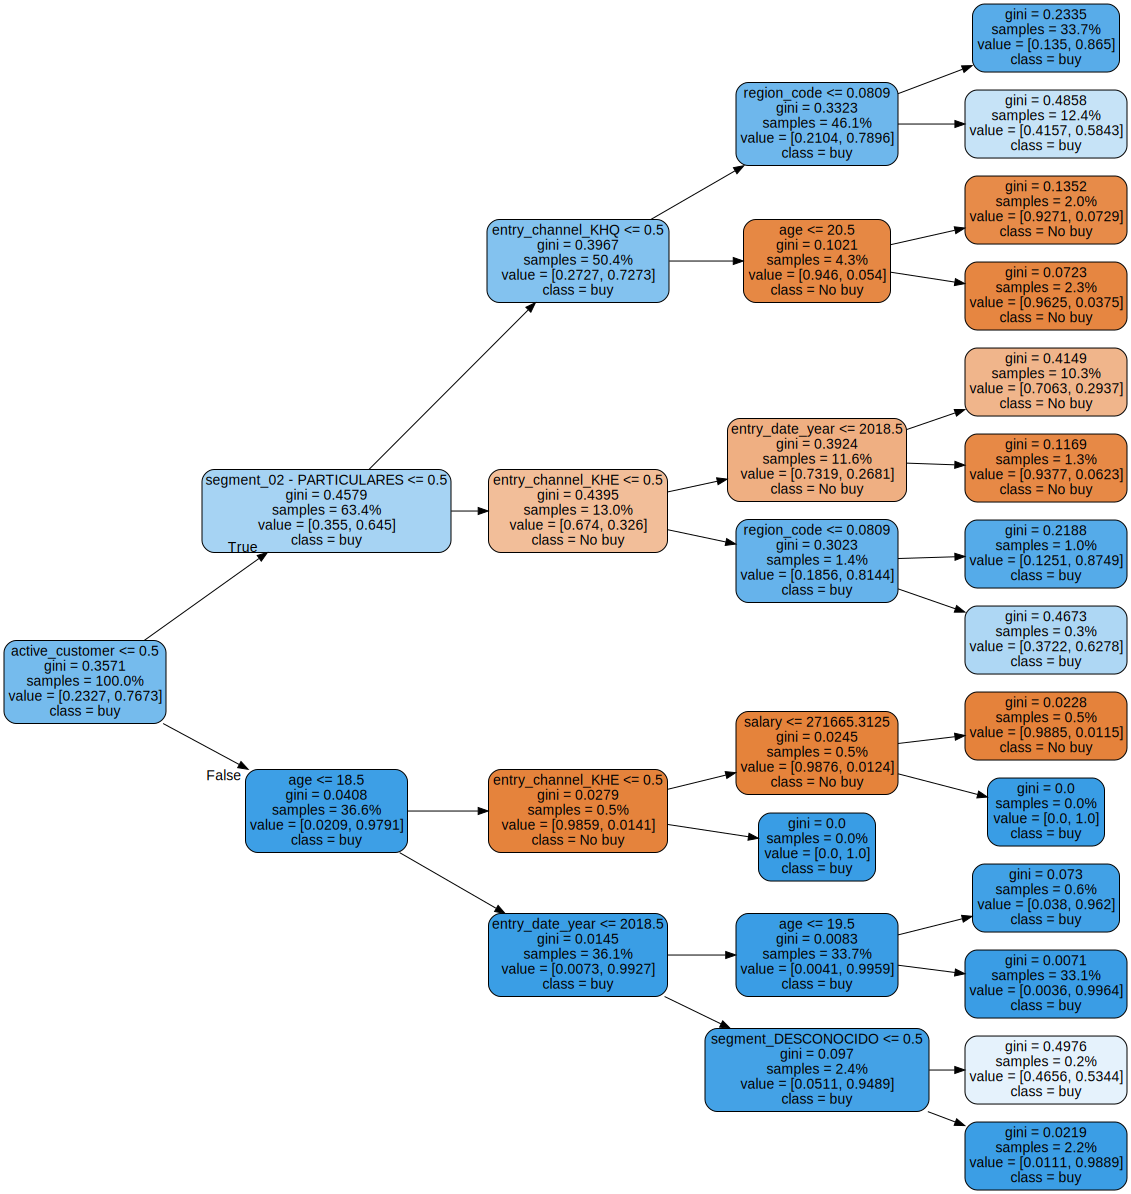

In [ ]:
graphviz.Source(dot_data, format = 'png')

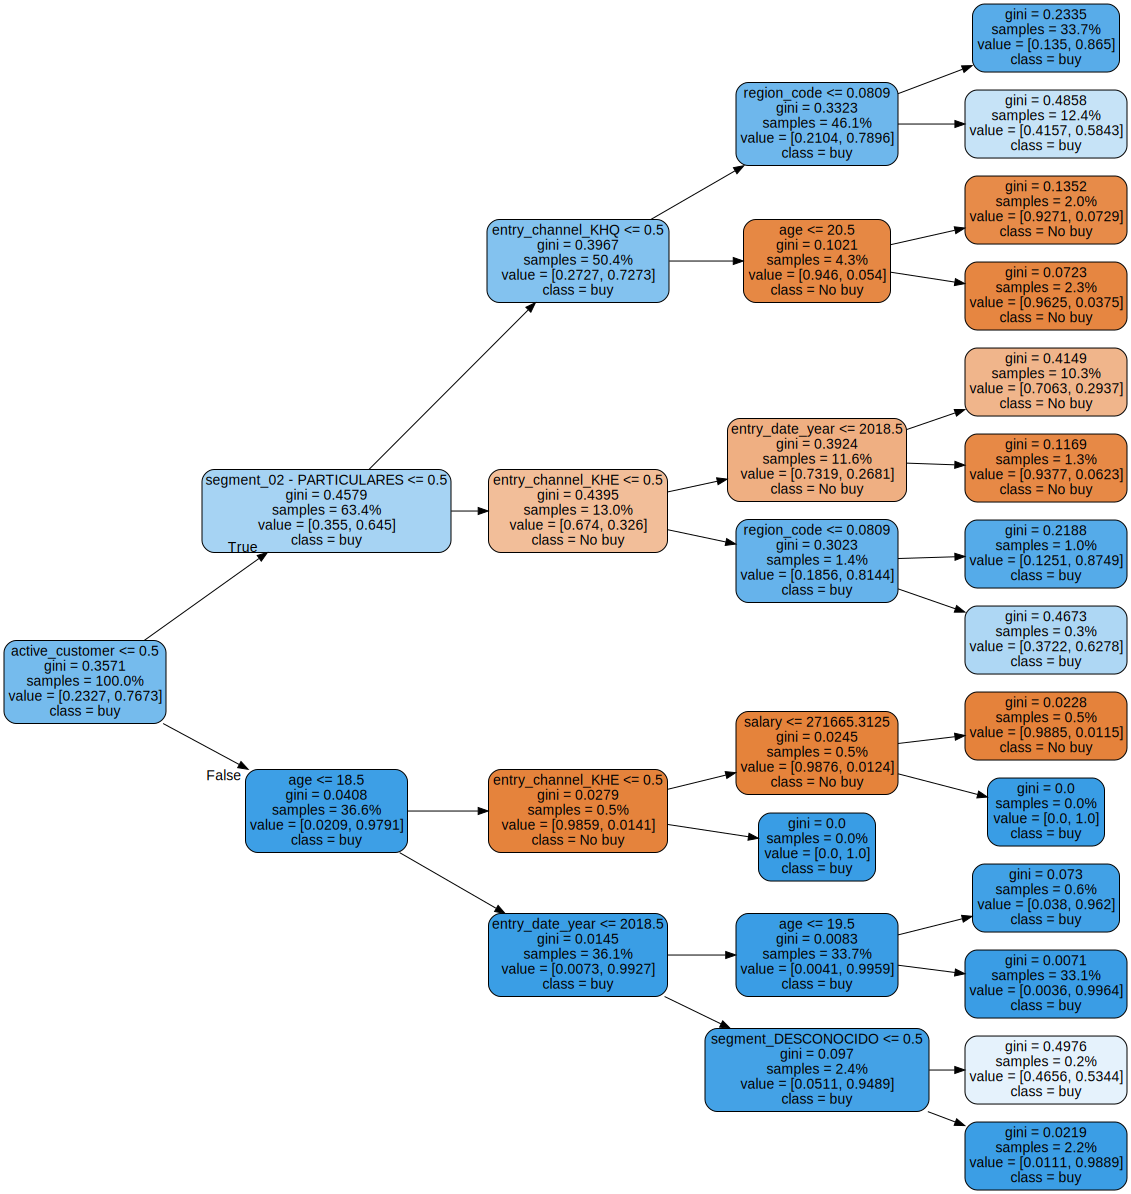

In [ ]:
graph = graphviz.Source(dot_data)
graph

Utilizamos al modelo para obtener el acuracy.

In [ ]:
dt.score(X_test, y_test)

0.8658518765916586

## Xgboost

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

In [ ]:
# Crear un modelo XGBoost para clasificación con hiperparámetros ajustados
xgboost_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, eval_metric='logloss')

# Entrenar el modelo solo con X_train e y_train
xgboost_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba (X_test)
y_pred_test = xgboost_model.predict(X_test)

# Evaluar el modelo con métricas adicionales en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Mostrar las métricas de evaluación en el conjunto de prueba
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

# ---- Evaluación adicional en el conjunto de validación ----

# Hacer predicciones sobre el conjunto de validación (val_X)
y_pred_val = xgboost_model.predict(val_X)

# Evaluar el modelo con métricas adicionales en el conjunto de validación
val_accuracy = accuracy_score(val_y, y_pred_val)
val_f1 = f1_score(val_y, y_pred_val)

# Mostrar las métricas de evaluación en el conjunto de validación
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1-Score: {val_f1:.4f}')


Test Accuracy: 0.8863
Test F1-Score: 0.9278
Validation Accuracy: 0.8852
Validation F1-Score: 0.9267


Obtenemos un primer Accuracy de **0.885** en validación

### Pruebas de hiperparámetro

Vamos a modificar los hiperparámetros del modelo para mejorar su Accuray y controlar el overfitying.

In [ ]:
for i in range(1, 10):
    xgboost_model = xgb.XGBClassifier(max_depth=i, random_state=42)
    xgboost_model.fit(X_train, y_train)
    train_accuracy = xgboost_model.score(X_train, y_train)
    test_accuracy = xgboost_model.score(X_test, y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.8687517053511122 - Test: 0.870569448503319
Profundidad del árbol: 2. Train: 0.8917476661850681 - Test: 0.8917463365757943
Profundidad del árbol: 3. Train: 0.898613801154942 - Test: 0.897570241723375
Profundidad del árbol: 4. Train: 0.904097763026646 - Test: 0.9027679205110007
Profundidad del árbol: 5. Train: 0.9064863728467846 - Test: 0.904041247442909
Profundidad del árbol: 6. Train: 0.9097024973049861 - Test: 0.9045944140608692
Profundidad del árbol: 7. Train: 0.9130125558572381 - Test: 0.9048553417108505
Profundidad del árbol: 8. Train: 0.917199332620627 - Test: 0.9042604266688933
Profundidad del árbol: 9. Train: 0.9219139295315373 - Test: 0.9031123450089759


Vemos como con un max_depth de 8 obtenemos el mayor accuracy en validacion sin distar mucho de lo obtenido en train.

Ajustamos ahora el n_stimators para intentar obtener el mayor accuracy posible sin llegar a overfiting.

In [ ]:
  # Crear un modelo XGBoost para clasificación con hiperparámetros ajustados
  xgboost_model = xgb.XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=8, eval_metric='logloss')

  # Entrenar el modelo solo con X_train e y_train
  xgboost_model.fit(X_train, y_train)

  # Hacer predicciones sobre el conjunto de prueba (X_test)
  y_pred_test = xgboost_model.predict(X_test)

  # Evaluar el modelo con métricas adicionales en el conjunto de prueba
  test_accuracy = accuracy_score(y_test, y_pred_test)
  test_f1 = f1_score(y_test, y_pred_test)

  # Mostrar las métricas de evaluación en el conjunto de prueba
  print(f'Test Accuracy: {test_accuracy:.4f}')
  print(f'Test F1-Score: {test_f1:.4f}')

  # ---- Evaluación adicional en el conjunto de validación ----

  # Hacer predicciones sobre el conjunto de validación (val_X)
  y_pred_val = xgboost_model.predict(val_X)

  # Evaluar el modelo con métricas adicionales en el conjunto de validación
  val_accuracy = accuracy_score(val_y, y_pred_val)
  val_f1 = f1_score(val_y, y_pred_val)

  # Mostrar las métricas de evaluación en el conjunto de validación
  print(f'Validation Accuracy: {val_accuracy:.4f}')
  print(f'Validation F1-Score: {val_f1:.4f}')

Test Accuracy: 0.9048
Test F1-Score: 0.9384
Validation Accuracy: 0.9033
Validation F1-Score: 0.9372


Obtenemos un **Accuracy en Validación del 0.9033**!!!

### Model evaluation

Pasamos a predecir que clientes compraran algun producto.

In [ ]:
y_test_pred = pd.DataFrame(xgboost_model.predict(X_test), index=y_test.index, columns=['ProductsPrediction'])

In [ ]:
y_test_pred.head()

,ProductsPrediction
282291,1
324288,1
220452,1
366696,1
252719,1


In [ ]:
y_test = pd.DataFrame(y_test)

In [ ]:
y_test.shape

(95812, 1)

In [ ]:
y_test_pred.shape

(95812, 1)

In [ ]:
results_df = y_test.join(y_test_pred, how= 'inner')

In [ ]:
results_df['Success'] = (results_df['target'] == results_df['ProductsPrediction']).astype(int)

Comparamos en esta tabla el valor del target que tenemos en nuestros datos y el valor que predice nuestro modelo.

In [ ]:
results_df.head(20)

,target,ProductsPrediction,Success
282291,1,1,1
324288,1,1,1
220452,1,1,1
366696,0,1,0
252719,1,1,1
274092,1,1,1
318014,1,1,1
425885,0,0,1
468,1,1,1
187717,1,1,1


In [ ]:
results_df['Success'].count()

95812

In [ ]:
results_df['Success'].sum()

86687

In [ ]:
results_df['Success'].mean()

0.9047614077568572

In [ ]:
print('Hemos acertado {} registros de un total de {}, por tanto el Accuracy en test es {}.'.format(results_df['Success'].sum(), results_df['Success'].count(), results_df['Success'].mean()))

Hemos acertado 86687 registros de un total de 95812, por tanto el Accuracy en test es 0.9047614077568572.


### Matriz de confusión

Otra forma de obtener este valor es con la Confuson Matrix.

In [ ]:
confusion_matrix = pd.crosstab(results_df['target'], results_df['ProductsPrediction'])

In [ ]:
confusion_matrix

ProductsPrediction,0,1
target,,
0,17238,4764
1,4361,69449


De esta matriz, interpretamos que tenemos:

*   17.238 casos en los que nuestro modelo predice 'No compra' y es correcto.
*   69.449 casos en los que nuestro modelo predice 'Compra' y es correcto.
*   4.764 casos en los que nuestro modelo predice 'Compra' y es erróneo.
*   4.361 casos en los que nuestro modelo predice 'No compra' y es erróneo.




In [ ]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'El accuracy en test es de {accuracy}')

El accuracy en test es de 0.9047614077568572


### Evaluar el modelo de forma probabilista, obteniendo los scorings y no el valor de predicción

In [ ]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=y_test.index, columns=['Score'])

In [ ]:
results_df = results_df.join(y_score)

Obtenemos el Score: Probabilidad de que una observación pertenezca a la clase positiva (multiplicar x100 para obtener el %)

In [ ]:
results_df.head(10)

,target,ProductsPrediction,Success,Score
282291,1,1,1,0.996444
324288,1,1,1,0.996444
220452,1,1,1,0.865035
366696,0,1,0,0.996444
252719,1,1,1,0.996444
274092,1,1,1,0.865035
318014,1,1,1,0.865035
425885,0,0,1,0.072912
468,1,1,1,0.996444
187717,1,1,1,0.996444


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95812 entries, 282291 to 372018
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target              95812 non-null  int64  
 1   ProductsPrediction  95812 non-null  int64  
 2   Success             95812 non-null  int64  
 3   Score               95812 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 5.7 MB


Resumen de la relación entre el "puntaje" ('Score') y el "éxito" ('Success'). Podemos ver como  se distribuyen los puntajes predichos y cuántos de ellos corresponden a éxitos, ayudando a evaluar el rendimiento de un modelo de clasificación.

En esta tabla:


*   **Score**: Probabilidad de que una observación pertenezca a la clase positiva (multiplicar x100 para obtener el %)
*   **len**: representa el número de observaciones que hay con ese score.
*   **sum**: el numero de éxitos que obtenemos.
*   **mean**: la tasa de éxito.






In [ ]:
results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean]).sort_values(by='Score', ascending=False)

<ipython-input-1958-c01c549d74cb>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean]).sort_values(by='Score', ascending=False)
<ipython-input-1958-c01c549d74cb>:1: FutureWarning: The provided callable <function mean at 0x7e66d026d000> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean]).sort_values(by='Score', ascending=False)


,len,sum,mean
,Success,Success,Success
Score,,,
1.000000,1,1,1.000000
0.996444,31602,31496,0.996646
0.988914,2151,2122,0.986518
0.962045,553,529,0.956600
0.874946,954,839,0.879455
0.865035,32744,29500,0.900928
0.627815,331,238,0.719033
0.584319,11757,9339,0.794335


In [ ]:
results_by_score = results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean])

<ipython-input-1959-731a9948af02>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  results_by_score = results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean])
<ipython-input-1959-731a9948af02>:1: FutureWarning: The provided callable <function mean at 0x7e66d026d000> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  results_by_score = results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean])


In [ ]:
results_by_score.columns = ['Count', 'Sum', 'Mean']

Vemos la distribución de las probabilidades de acierto del modelo.

<Axes: xlabel='Score'>

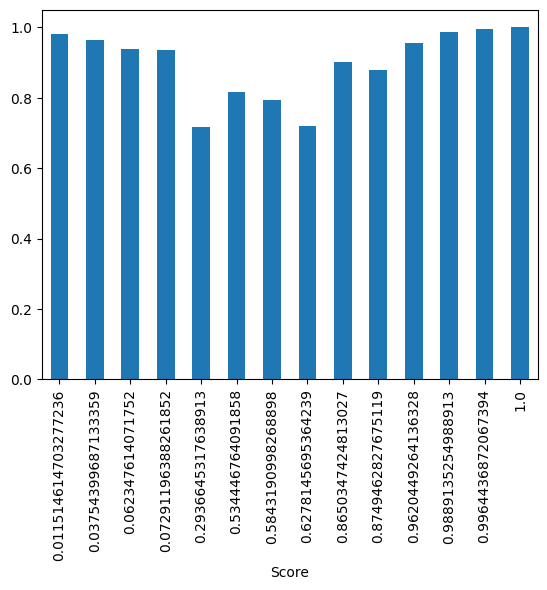

In [ ]:
results_by_score['Mean'].plot(kind='bar')

# df_compras_em_acount - Modelling

Repetimos el proceso de modelling, para el nuevo dataset que hemos creado para el producto deseado.

Esta vez predeciremos las **compras em_acount**

## Train / Test Split

En primer lugar, importaremos los scikits de estrategias de validación y selección de modelos model_selection y métricas de validación metrics.

In [ ]:
from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics

### Generación de la partición de validación

En este dataset tenemos una foto de todos los clientes que tenemos en 2019-05, con los productos que tienen activos.


En un primero momento nos quedaremos con un 30% de los registros para la parte de Validación.

In [ ]:
df_compras_em_acount['target'].value_counts()

,count
target,
1,332728
0,123645


In [ ]:
len(df_compras_em_acount)*0.3

136911.9

Para la parte de valicion tomaremos de manera aleatoria 137.000 registros.

In [ ]:
em_acount_sample = df_compras_em_acount.sample(n=137000, random_state=42)

De nuestro dataset orignal, eliminamos los registros aleatorios que tomaremos para validacion.

In [ ]:
em_acount_train = df_compras_em_acount.drop(em_acount_sample.index)

In [ ]:
val_df = em_acount_sample
dev_df = em_acount_train

In [ ]:
dev_X = dev_df.drop('target',axis = 1)
dev_y = dev_df['target']

val_X = val_df.drop('target',axis = 1)
val_y = val_df['target']

## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        dev_X, # X
                                        dev_y, # y
                                        test_size = 0.30, # tamaño del split aleatorio
                                        random_state = 42
                                     )

Instanciamos el algoritmo.

In [ ]:
dt = DecisionTreeClassifier(
                        # criterion='gini',
                        # splitter='best',
                        max_depth=4, # Importante, regulará el sobreajuste
                        # min_samples_split=2,
                        # min_samples_leaf=1,
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None,
                        random_state=42,
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,
                )

Entrenamos al modelo.

In [ ]:
dt.fit(
    X=X_train,
    y=y_train,
    # sample_weight=None,
    # check_input=True,
    # X_idx_sorted=None
)

DecisionTreeClassifier(max_depth=4, random_state=42)

Visualizamos el arbol de decisiones.

In [ ]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No buy', 'buy'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

In [ ]:
import pydotplus
graph2 = pydotplus.graph_from_dot_data(dot_data)

In [ ]:
graph2.write_png("tree.png")

True

Podemos visualizar el camino que realiza nuestro modelo.

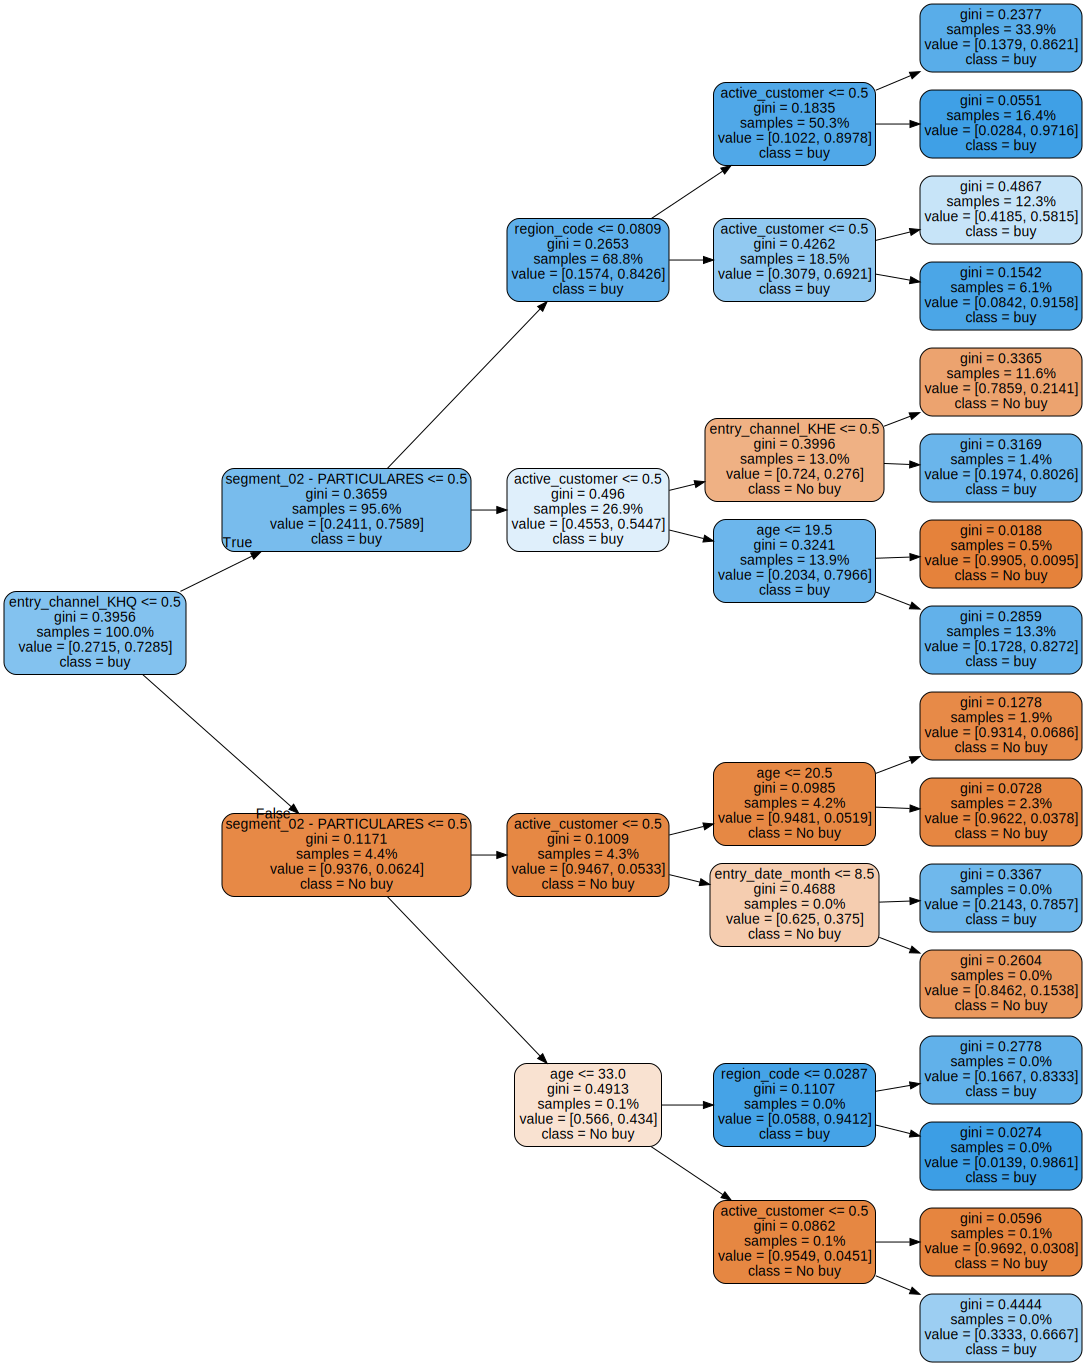

In [ ]:
graphviz.Source(dot_data, format = 'png')

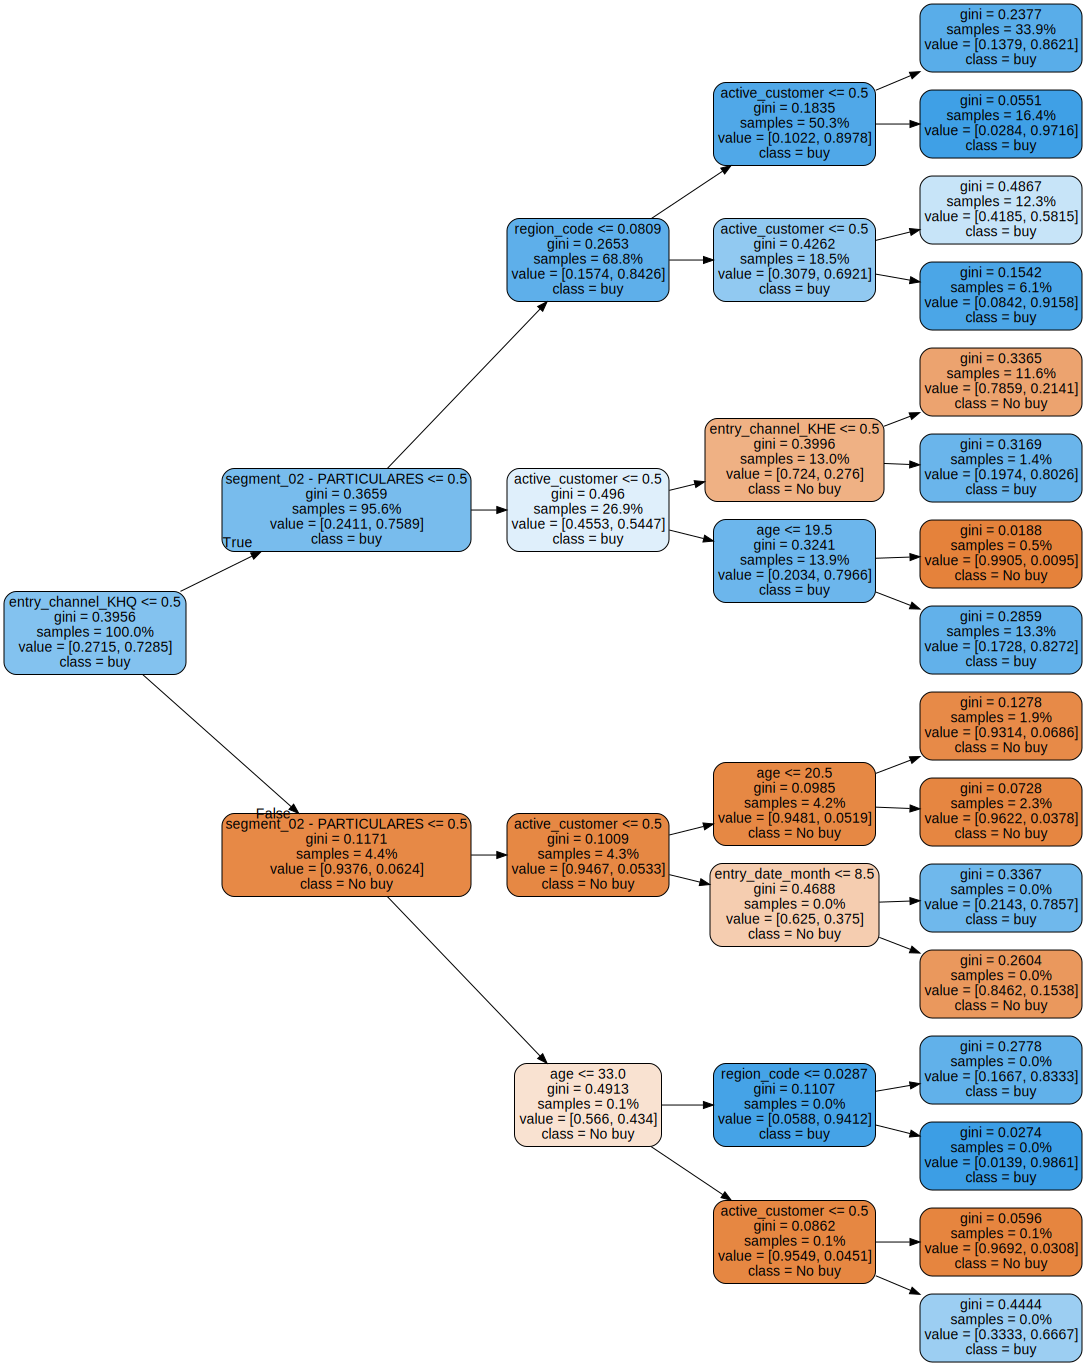

In [ ]:
graph = graphviz.Source(dot_data)
graph

Utilizamos al modelo para obtener el acuracy.

In [ ]:
dt.score(X_test, y_test)

0.8410846240554419

## Xgboost

Decidimos utilizar un **algoritmo** diferente, con el fin de obtener mejores resultados.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

In [ ]:
# Crear un modelo XGBoost para clasificación con hiperparámetros ajustados
xgboost_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')

# Entrenar el modelo solo con X_train e y_train
xgboost_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba (X_test)
y_pred_test = xgboost_model.predict(X_test)

# Evaluar el modelo con métricas adicionales en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Mostrar las métricas de evaluación en el conjunto de prueba
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

# ---- Evaluación adicional en el conjunto de validación ----

# Hacer predicciones sobre el conjunto de validación (val_X)
y_pred_val = xgboost_model.predict(val_X)

# Evaluar el modelo con métricas adicionales en el conjunto de validación
val_accuracy = accuracy_score(val_y, y_pred_val)
val_f1 = f1_score(val_y, y_pred_val)

# Mostrar las métricas de evaluación en el conjunto de validación
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1-Score: {val_f1:.4f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:51:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.8625
Test F1-Score: 0.9095
Validation Accuracy: 0.8620
Validation F1-Score: 0.9089


En una primer ejecución obtenemos un **0.862 de Accuracy en Validación**

### Pruebas de hiperparámetro

Probamos ahora con el ajuste de hiperparámetros para mejorar el Accuracy y controlar el Overfitting.

In [ ]:
for i in range(1, 15):
    xgboost_model = xgb.XGBClassifier(max_depth=i, random_state=42)
    xgboost_model.fit(X_train, y_train)
    train_accuracy = xgboost_model.score(X_train, y_train)
    test_accuracy = xgboost_model.score(X_test, y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.8428885181225706 - Test: 0.8448419822151714
Profundidad del árbol: 2. Train: 0.8661752273428729 - Test: 0.8666555337536008
Profundidad del árbol: 3. Train: 0.8746248227553106 - Test: 0.8747234166910199
Profundidad del árbol: 4. Train: 0.879164970634413 - Test: 0.8786164572287396
Profundidad del árbol: 5. Train: 0.8819785204038272 - Test: 0.8807769381705841
Profundidad del árbol: 6. Train: 0.8848770581630965 - Test: 0.8809752431845698
Profundidad del árbol: 7. Train: 0.8872119913580634 - Test: 0.8815492840145285
Profundidad del árbol: 8. Train: 0.8915642710490649 - Test: 0.8815910324385254
Profundidad del árbol: 9. Train: 0.8970124485039878 - Test: 0.8806934413225901
Profundidad del árbol: 10. Train: 0.9042901042668444 - Test: 0.8798375986306517
Profundidad del árbol: 11. Train: 0.9140771422564758 - Test: 0.8781989729887697
Profundidad del árbol: 12. Train: 0.9196013615970585 - Test: 0.8767377781488749
Profundidad del árbol: 13. Train: 0.93107921327959

Vemos como con un max_depth de 8 obtenemos el mayor accuracy en validacion sin distar mucho de lo obtenido en train.

Ajustamos ahora el n_stimators para intentar obtener el mayor accuracy posible sin llegar a overfiting.

In [ ]:
# Crear un modelo XGBoost para clasificación con hiperparámetros ajustados
xgboost_model = xgb.XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=8, eval_metric='logloss')

# Entrenar el modelo solo con X_train e y_train
xgboost_model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba (X_test)
y_pred_test = xgboost_model.predict(X_test)

# Evaluar el modelo con métricas adicionales en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

# Mostrar las métricas de evaluación en el conjunto de prueba
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

# ---- Evaluación adicional en el conjunto de validación ----
# Hacer predicciones sobre el conjunto de validación (val_X)
y_pred_val = xgboost_model.predict(val_X)

# Evaluar el modelo con métricas adicionales en el conjunto de validación
val_accuracy = accuracy_score(val_y, y_pred_val)
val_f1 = f1_score(val_y, y_pred_val)

# Mostrar las métricas de evaluación en el conjunto de validación
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation F1-Score: {val_f1:.4f}')

Test Accuracy: 0.8820
Test F1-Score: 0.9211
Validation Accuracy: 0.8813
Validation F1-Score: 0.9204


Obtenemos un Accuracy en Validación del 0.8981!!!

### Model evaluation

Predecimos que clientes comprarán nuestro producto: **em_acount**

In [ ]:
y_test_pred = pd.DataFrame(xgboost_model.predict(X_test), index=y_test.index, columns=['ProductsPrediction'])

In [ ]:
y_test_pred.head()

,ProductsPrediction
282291,1
324288,1
220452,1
366696,0
252719,1


In [ ]:
y_test = pd.DataFrame(y_test)

In [ ]:
y_test.shape

(95812, 1)

In [ ]:
y_test_pred.shape

(95812, 1)

In [ ]:
results_df = y_test.join(y_test_pred, how= 'inner')

In [ ]:
results_df['Success'] = (results_df['target'] == results_df['ProductsPrediction']).astype(int)

Comparamos en esta tabla el valor del target que tenemos en nuestros datos y el valor que predice nuestro modelo.

In [ ]:
results_df.head(20)

,target,ProductsPrediction,Success
282291,1,1,1
324288,1,1,1
220452,1,1,1
366696,0,0,1
252719,1,1,1
274092,1,1,1
318014,1,1,1
425885,0,0,1
468,1,1,1
187717,1,1,1


In [ ]:
results_df['Success'].count()

95812

In [ ]:
results_df['Success'].sum()

84509

In [ ]:
results_df['Success'].mean()

0.8820293908904939

In [ ]:
print('Hemos acertado {} registros de un total de {}, por tanto el Accuracy en test es {}.'.format(results_df['Success'].sum(), results_df['Success'].count(), results_df['Success'].mean()))

Hemos acertado 84509 registros de un total de 95812, por tanto el Accuracy en test es 0.8820293908904939.


### Matriz de confusión

Otra forma de obtener este valor es con la Confuson Matrix.

In [ ]:
confusion_matrix = pd.crosstab(results_df['target'], results_df['ProductsPrediction'])

In [ ]:
confusion_matrix

ProductsPrediction,0,1
target,,
0,18506,7268
1,4035,66003


De esta matriz, interpretamos que tenemos:

18.506 casos en los que nuestro modelo predice 'No compra' y es correcto.
66.003 casos en los que nuestro modelo predice 'Compra' y es correcto.
7.268 casos en los que nuestro modelo predice 'Compra' y es erróneo.
4.035 casos en los que nuestro modelo predice 'No compra' y es erróneo.

In [ ]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'El accuracy en test es de {accuracy}')

El accuracy en test es de 0.8820293908904939


### Evaluar el modelo de forma probabilista, obteniendo los scorings y no el valor de predicción

In [ ]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=y_test.index, columns=['Score'])

In [ ]:
results_df = results_df.join(y_score)

Obtenemos el Score: Probabilidad de que una observación pertenezca a la clase positiva (multiplicar x100 para obtener el %)

In [ ]:
results_df.head(10)

,target,ProductsPrediction,Success,Score
282291,1,1,1,0.915830
324288,1,1,1,0.915830
220452,1,1,1,0.827160
366696,0,0,1,0.581504
252719,1,1,1,0.915830
274092,1,1,1,0.862136
318014,1,1,1,0.971630
425885,0,0,1,0.214110
468,1,1,1,0.827160
187717,1,1,1,0.971630


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95812 entries, 282291 to 372018
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target              95812 non-null  int64  
 1   ProductsPrediction  95812 non-null  int64  
 2   Success             95812 non-null  int64  
 3   Score               95812 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 5.7 MB


In [ ]:
results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean]).sort_values(by='Score', ascending=False)

<ipython-input-2003-c01c549d74cb>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean]).sort_values(by='Score', ascending=False)
<ipython-input-2003-c01c549d74cb>:1: FutureWarning: The provided callable <function mean at 0x7e66d026d000> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean]).sort_values(by='Score', ascending=False)


,len,sum,mean
,Success,Success,Success
Score,,,
0.986111,43,42,0.976744
0.971630,15598,15219,0.975702
0.915830,5933,5514,0.929378
0.862136,32559,29212,0.897202
0.833333,13,13,1.000000
0.827160,12881,10917,0.847527
0.802554,1312,1109,0.845274
0.785714,3,2,0.666667


En esta tabla:


*   **Score**: Probabilidad de que una observación pertenezca a la clase positiva (multiplicar x100 para obtener el %)
*   **len**: representa el número de observaciones que hay con ese score.
*   **sum**: el numero de éxitos que obtenemos.
*   **mean**: la tasa de éxito.







In [ ]:
results_by_score = results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean])

<ipython-input-2004-731a9948af02>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  results_by_score = results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean])
<ipython-input-2004-731a9948af02>:1: FutureWarning: The provided callable <function mean at 0x7e66d026d000> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  results_by_score = results_df.pivot_table(index='Score', values='Success', aggfunc=[len, sum, np.mean])


In [ ]:
results_by_score.columns = ['Count', 'Sum', 'Mean']

<Axes: xlabel='Score'>

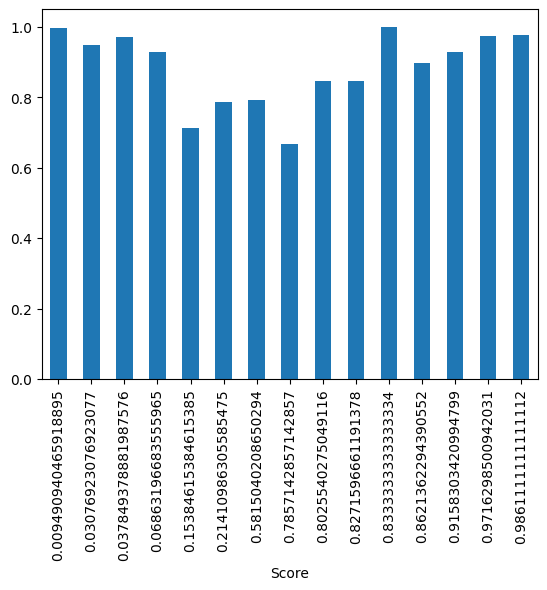

In [ ]:
results_by_score['Mean'].plot(kind='bar')

# Cluster

## Importar dataset y cargar librerías

In [ ]:
df = active_products.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## EDA

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   pk_partition                456373 non-null  object 
 1   short_term_deposit          456373 non-null  int64  
 2   loans                       456373 non-null  int64  
 3   mortgage                    456373 non-null  int64  
 4   funds                       456373 non-null  int64  
 5   securities                  456373 non-null  int64  
 6   long_term_deposit           456373 non-null  int64  
 7   credit_card                 456373 non-null  int64  
 8   payroll                     456373 non-null  int64  
 9   pension_plan                456373 non-null  int64  
 10  payroll_account             456373 non-null  int64  
 11  emc_account                 456373 non-null  int64  
 12  debit_card                  456373 non-null  int64  
 13  em_account_p  

Eliminamos algunas columnas que no nos sirven:


In [ ]:
df = df.drop(columns=['country_id_ES','gender_H', 'region_code', 'deceased','entry_date_year','entry_date_month','entry_channel_KAT' ,'entry_channel_KAZ','entry_channel_KBG','entry_channel_KFA', 'entry_channel_KFC', 'entry_channel_KHC','entry_channel_KHE','entry_channel_KHF','entry_channel_KHD','entry_channel_KHK','entry_channel_KHL','entry_channel_KHM','entry_channel_KHN','entry_channel_KHO','entry_channel_KHQ','entry_channel_RED'])

In [ ]:
from datetime import datetime

# Define the reference dat
df['pk_partition'] = pd.to_datetime(df['pk_partition'])
df['entry_date'] = pd.to_datetime(df['entry_date'])

reference_date = df['pk_partition'].max()

# Calculate the difference in days
df['entry_date'] = (reference_date - df['entry_date']).dt.days

print(df[['pk_partition', 'entry_date']].head())

  pk_partition  entry_date
0   2018-08-01         304
1   2019-05-01         181
2   2019-05-01         151
3   2019-05-01         242
4   2019-05-01         607


In [ ]:
df['entry_date'].nunique()

53

In [ ]:
 df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_partition                456373 non-null  datetime64[ns]
 1   short_term_deposit          456373 non-null  int64         
 2   loans                       456373 non-null  int64         
 3   mortgage                    456373 non-null  int64         
 4   funds                       456373 non-null  int64         
 5   securities                  456373 non-null  int64         
 6   long_term_deposit           456373 non-null  int64         
 7   credit_card                 456373 non-null  int64         
 8   payroll                     456373 non-null  int64         
 9   pension_plan                456373 non-null  int64         
 10  payroll_account             456373 non-null  int64         
 11  emc_account                 456373 non-

In [ ]:
df.drop(columns=['pk_partition'], inplace=True)

## Data preparation

### Normalizacion de los datos

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

### Elbow curve

Definimos un rango de posibles numero de cluster

In [ ]:
#range_n_clusters = range(1, 50)
range_n_clusters = range(1, 20)
inertia = []

In [ ]:
# Calcula la inercia para cada número de clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

In [ ]:
import matplotlib.pyplot as plt

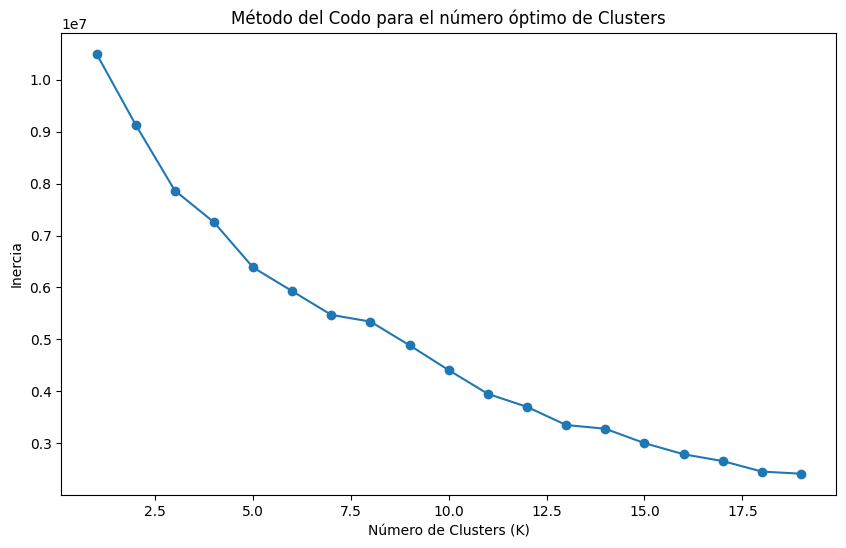

In [ ]:
# Grafica la curva del codo
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método del Codo para el número óptimo de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.show()

## Aplicar K-Means

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

## Perfiles de cada cluster

Media de los cluster

In [ ]:
cluster_profiles = df.groupby('Cluster').mean()
cluster_profiles.T

Cluster,0,1,2,3,4,5,6,7
short_term_deposit,0.000249,0.062183,0.007911,0.004255,0.000,0.033155,0.001686,0.063664
loans,0.000029,0.000132,0.000802,0.000000,0.000,0.000000,0.000047,0.000601
mortgage,0.000000,0.000000,0.000000,0.000000,1.000,0.000000,0.000000,0.000000
funds,0.000000,0.000000,0.000000,0.000000,0.040,0.000000,0.000000,1.000000
securities,0.000000,0.000000,0.000000,0.000000,0.000,1.000000,0.000000,0.131532
long_term_deposit,0.000260,0.096255,0.025703,0.009630,0.000,0.094118,0.001466,0.399399
credit_card,0.000917,0.041363,0.148055,0.000448,0.520,0.165775,0.007690,0.154955
payroll,0.000000,0.000026,0.954975,0.002688,0.760,0.222995,0.000000,0.143544
pension_plan,0.000007,0.000487,0.998578,0.002688,0.760,0.234225,0.000504,0.157357
payroll_account,0.004227,0.031453,0.973969,0.002464,0.720,0.247059,0.007848,0.187387


In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
0,277011
1,75986
6,63457
2,27429
3,8930
5,1870
7,1665
4,25


In [ ]:
df['Cluster'] = df['Cluster'].replace(4, 6)

In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
0,277011
1,75986
6,63482
2,27429
3,8930
5,1870
7,1665


In [ ]:
nomb_clusters = {0: 'Universitarios',1: 'Básico',2: 'Ahorrador Multiproducto', 3:'Desconocido', 5:'Familias', 6:'Particulares Inactivos', 7: 'Inversores'}
df['Cluster'] = df['Cluster'].map(nomb_clusters)

In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
Universitarios,277011
Básico,75986
Particulares Inactivos,63482
Ahorrador Multiproducto,27429
Desconocido,8930
Familias,1870
Inversores,1665


In [ ]:
cluster_profiles = df.groupby('Cluster').mean()
cluster_profiles.T

Cluster,Ahorrador Multiproducto,Básico,Desconocido,Familias,Inversores,Particulares Inactivos,Universitarios
short_term_deposit,0.007911,0.062183,0.004255,0.033155,0.063664,0.001686,0.000249
loans,0.000802,0.000132,0.000000,0.000000,0.000601,0.000047,0.000029
mortgage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000394,0.000000
funds,0.000000,0.000000,0.000000,0.000000,1.000000,0.000016,0.000000
securities,0.000000,0.000000,0.000000,1.000000,0.131532,0.000000,0.000000
long_term_deposit,0.025703,0.096255,0.009630,0.094118,0.399399,0.001465,0.000260
credit_card,0.148055,0.041363,0.000448,0.165775,0.154955,0.007892,0.000917
payroll,0.954975,0.000026,0.002688,0.222995,0.143544,0.000299,0.000000
pension_plan,0.998578,0.000487,0.002688,0.234225,0.157357,0.000803,0.000007
payroll_account,0.973969,0.031453,0.002464,0.247059,0.187387,0.008128,0.004227


## Margen de los productos

In [ ]:
net_margin_by_product = pd.DataFrame(sales.groupby('product_ID')['net_margin'].mean().round(2))

In [ ]:
net_margin_by_product

,net_margin
product_ID,
1119,1499.05
1364,5976.44
2234,69.93
2235,69.97
2312,60.02
2335,1486.43
2336,1496.92
2673,1497.83
3819,60.00


In [ ]:
margen_productos = pd.merge(net_margin_by_product, products_description,how='inner',left_on=['product_ID'],right_on=['pk_product_ID'])

In [ ]:
margen_productos.sort_values(by='net_margin', ascending=False)

,net_margin,pk_product_ID,product_desc,family_product
1,5976.44,1364,pension_plan,pension_plan
9,2532.51,4033,mortgage,loan
12,2183.92,9001,loans,loan
0,1499.05,1119,funds,investment
7,1497.83,2673,securities,investment
6,1496.92,2336,long_term_deposit,investment
5,1486.43,2335,short_term_deposit,investment
11,70.01,8871,emc_account,account
3,69.97,2235,payroll_account,account
10,69.97,4657,em_acount,account


## Campañas de Marketing

### ¡Compra tu primer coche! - LOANS y SECURITIES.

*   Ofrecemos prestamos llamativos a universitarios (277.011) y clientes básicos(75.986) enfocados a que se compren su primer coche y además venderles también el seguro.

*   Clientes afectados: universitarios (277.011 * 0.246) + Clientes básicos(75986 * 0.918353)

*   Niguno de los dos grupos, tiene contratado este producto (menos de un 1% en ambos clusters), por lo que podemos ofrecerselo a todos los clientes.

*   Valor del mercado LOANS: clientes cluster * clientes activos * ganancia media del producto 301.378.725€

*   Valor del mercado SECURITIES: clientes cluster * clientes activos * ganancia media del producto 206.699.007€

*   Valor total del mercado: 508.077.733€






In [ ]:
((277011 * 0.246261	 + 75986 * 0.918353) * 2183.92) + ((277011 * 0.246261	 + 75986 * 0.918353) * 1497.83)

508077733.3083457

In [ ]:
((277011 * 0.246261	 + 75986 * 0.918353) * 1497.83)

206699007.61356404

### ¡Inversion a largo plazo! - LONG_TERM_DEPOSIT

*   Ofrecemos inversión a largo plazo con nuestro deposito a los Ahorradores Multiproducto
* Clientes afectado: Ahorradores multiproductos(27.429 * 0.943345)
*   De este grupo un 2.57%, ya tiene contratado este producto.
*   Valor del mercado: clientes cluster * clientes activos * ganancia media del producto: 37.737.270€

In [ ]:
(27429 * 0.943345) * (1-0.025703) * 1496.92

37737270.304823875

###¡Jubilate lo antes posible! - PENSION_PLAN

*   Ofrecemos planes de pensiones a nuestros clientes de mayor edad, con alto capital
* Clientes afectado: Familias(1870 * 0.970588) e Inversores (1665 * 0.947748)
*   Del grupo de las Familias solo un  23.4%, ya tiene contratado este producto.
*   Del grupo de Inversores un 15.7% ya tiene contratado este producto.
*   Valor del mercado: clientes cluster * clientes activos * ganancia media del producto: 16.253.360€

In [ ]:
(1870 * 0.970588 * (1-0.234225) + 1665 * 0.947748 * (1-0.157357)) * 5976.44

16253360.652521329